In [239]:
import os 
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## load files and preprocess

In [240]:
workdir = r'./processed/20230704_PRISM3D_mousebrain_CTX_rm_doublet/'

In [ ]:
rna_df = pd.read_csv(os.path.join(workdir, 'mapped_genes_processed'))

# read cell centroid
centroids = pd.read_csv(os.path.join(workdir, 'dapi_predict.csv'), index_col=0).to_numpy(dtype=np.float64)
centroids[:,0] *= 3.36
centroids[:,1] *= 1
centroids[:,2] *= 1
print(f'centroid_num:\t{len(centroids)}')

# cell info 

## cell_info: centroid

In [166]:
cell_info_dict = dict()
cell_info_dict['Cell Index'] = []
cell_info_dict['ce_z_in_pix'] = []
cell_info_dict['ce_x_in_pix'] = []
cell_info_dict['ce_y_in_pix'] = []

for index in rna_df['Cell Index'].unique():
    z, x, y = centroids[index]
    cell_info_dict['Cell Index'].append(int(index))
    cell_info_dict['ce_z_in_pix'].append(z)
    cell_info_dict['ce_x_in_pix'].append(x)
    cell_info_dict['ce_y_in_pix'].append(y)

cell_info = pd.DataFrame(cell_info_dict)
cell_info = cell_info.sort_values(by='Cell Index')
cell_info = cell_info.set_index('Cell Index')

## cell_info: cell type

In [167]:
import scanpy as sc

adata = sc.read_h5ad(os.path.join(workdir, 'adata.h5ad'))
indices = [int(_) for _ in adata.obs.index]
adata.obs.index = [_ - min(indices) for _ in indices]
cell_info['type'] = adata.obs.type
cell_info['subtype'] = adata.obs.subtype

In [168]:
cell_info = cell_info.loc[cell_info['type'].dropna().index]
# cell_info = cell_info[cell_info['type']!='other']

In [169]:
cell_info.to_csv(os.path.join(workdir, 'cell_info.csv'))

## rna_info: in nucleus

In [170]:
import tifffile


with tifffile.TiffFile(os.path.join(workdir, 'cell_segment' ,'dapi_predict.tif')) as tif:
    dapi_predict = tif.asarray()

rna_df['in_nu'] = [False] * len(rna_df)
for index in tqdm(rna_df.index):
    tmp = rna_df[rna_df['Cell Index']==index].copy()
    tmp['z_in_pix'] /= 3.36

    positions = tmp[['z_in_pix','x_in_pix','y_in_pix']].values
    positions = np.uint16(positions)

    results = []
    for pos in positions:
        z, y, x = pos
        if z < dapi_predict.shape[0] and y < dapi_predict.shape[1] and x < dapi_predict.shape[2]:
            results.append(bool(dapi_predict[z, y, x]))
        else:
            results.append(None)  # Position out of bounds

    rna_df['in_nu'].loc[tmp.index] = results

100%|██████████| 548304/548304 [11:22<00:00, 803.62it/s]


## cell_info: in nucleus ratio

In [171]:
cell_info['in_nu'] = [0] * len(cell_info)
for index in tqdm(cell_info.index):
    centroid = centroids[index]
    tmp_rnas = rna_df[rna_df['Cell Index']==index]
    cell_info.loc[index, 'in_nu'] = len(tmp_rnas[tmp_rnas['in_nu']==True]) / len(tmp_rnas)

100%|██████████| 26003/26003 [00:22<00:00, 1177.54it/s]


## cell_info: polar

In [172]:
from scipy.spatial.distance import euclidean


cell_info['polar'] = [0] * len(cell_info)
for index in tqdm(cell_info.index):
    centroid = centroids[index]
    tmp_rnas = rna_df[rna_df['Cell Index']==index]
    cell_info.loc[index, 'polar'] = euclidean(centroid, np.mean(tmp_rnas[['z_in_pix','x_in_pix','y_in_pix']].values, axis=0))

100%|██████████| 26003/26003 [00:25<00:00, 1032.23it/s]


## cell_info: average rna length and diameter of cells

In [173]:
from scipy.spatial import ConvexHull


def cal_average_length(rnas, centroid):
    distance = np.sqrt(np.diag((rnas - centroid) @ (rnas - centroid).T))
    # print(distance)
    mean_dis = np.mean(distance)
    return mean_dis


def calculate_diameter(points):
    # Compute the convex hull
    hull = ConvexHull(points)

    # Extract the points forming the convex hull
    hull_points = points[hull.vertices]

    # Calculate the diameter (max distance between any two points in the hull)
    diameter = max(np.linalg.norm(p1 - p2) for p1 in hull_points for p2 in hull_points)
    return diameter
    
dis = []
cell_radius = []


for index in tqdm(cell_info.index, desc='average rna dis'):
    tmp = rna_df[rna_df['Cell Index']==index]
    if len(tmp) < 5:
        dis.append(None)
        cell_radius.append(None)
        continue
    else:
        try:
            rnas = tmp[['z_in_pix','x_in_pix','y_in_pix']].values
            centroid = centroids[index]
            cell_radius.append(calculate_diameter(rnas)/2,)
            dis.append(cal_average_length(rnas, centroid))
            
        except: 
            dis.append(None)
            cell_radius.append(None)
            continue

cell_info['rna_ave_dis'] = dis
cell_info['cell_radius'] = cell_radius

average rna dis: 100%|██████████| 26003/26003 [01:02<00:00, 414.61it/s]


## cell_info: cell size

In [174]:
import tifffile
from tqdm import tqdm
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')


def extract_subarray_around_centroid(array, centroid, diffusion_distance=200):
    """
    Extract a sub-array from a 3D array centered around a given centroid.
    :param array: 3D numpy array.
    :param centroid: Tuple (x, y, z) representing the centroid.
    :param diffusion_distance: Distance to diffuse from the centroid in every direction.
    :return: Sub-array centered around the centroid.
    """
    z, x, y = centroid
    z_min, z_max = max(z - diffusion_distance, 0), min(z + diffusion_distance, array.shape[0])
    x_min, x_max = max(x - diffusion_distance, 0), min(x + diffusion_distance, array.shape[1])
    y_min, y_max = max(y - diffusion_distance, 0), min(y + diffusion_distance, array.shape[2])
    
    return array[z_min: z_max, x_min: x_max, y_min: y_max], (z - z_min, x - x_min, y - y_min)


def find_volume(array, centroid, target_label_mannual):
    z, x, y = centroid
    target_label = array[z, x, y]
    out = False
    if target_label == 0:
        out=True
        target_label = target_label_mannual

    tmp_label, centroid = extract_subarray_around_centroid(array, centroid)
    volume = np.sum(tmp_label == target_label)
    return volume, out

In [175]:
# Load the image
cell_convex = tifffile.imread(os.path.join(workdir, 'cell_segment', 'cell_convex.tif'))

In [176]:
cell_info['cell_volume'] = [np.nan] * len(cell_info)
attention = []
empty = []
for index in tqdm(cell_info.index, desc='Convex volume'):
    tmp = cell_info.loc[index]
    tmp['ce_z_in_pix'] /= 3.36
    centroid = [int(_) for _ in tmp[['ce_z_in_pix','ce_x_in_pix','ce_y_in_pix']].values]
    
    # Calculate the volume
    volume, out = find_volume(cell_convex, centroid, target_label_mannual = index+1)
    cell_info['cell_volume'].loc[index] = volume * 3.36
    if out:
        attention.append(index)
    if volume == 0:
        empty.append(index)

Convex volume: 100%|██████████| 26003/26003 [11:54<00:00, 36.41it/s]


## cell_info: nucleus size

In [177]:
import tifffile
from tqdm import tqdm
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')


def extract_subarray_around_centroid(array, centroid, diffusion_distance=100):
    """
    Extract a sub-array from a 3D array centered around a given centroid.
    :param array: 3D numpy array.
    :param centroid: Tuple (x, y, z) representing the centroid.
    :param diffusion_distance: Distance to diffuse from the centroid in every direction.
    :return: Sub-array centered around the centroid.
    """
    z, x, y = centroid
    z_min, z_max = max(z - diffusion_distance, 0), min(z + diffusion_distance, array.shape[0])
    x_min, x_max = max(x - diffusion_distance, 0), min(x + diffusion_distance, array.shape[1])
    y_min, y_max = max(y - diffusion_distance, 0), min(y + diffusion_distance, array.shape[2])
    
    return array[z_min: z_max, x_min: x_max, y_min: y_max], (z - z_min, x - x_min, y - y_min)


def find_volume(array, centroid):
    z, x, y = centroid
    target_label = array[z, x, y]

    if target_label == 0:
        return np.nan
    else:
        tmp_label, centroid = extract_subarray_around_centroid(array, centroid)
        volume = np.sum(tmp_label == target_label)
        return volume

In [178]:
# Load the image
dapi_predict = tifffile.imread(os.path.join(workdir, 'cell_segment', 'dapi_predict.tif'))

In [179]:
cell_info['nu_volume'] = [np.nan] * len(cell_info)
for index in tqdm(cell_info.index, desc='Nucleus volume'):
    tmp = cell_info.loc[index]
    tmp['ce_z_in_pix'] /= 3.36
    centroid = [int(_) for _ in tmp[['ce_z_in_pix','ce_x_in_pix','ce_y_in_pix']].values]
    
    # Calculate the volume
    cell_info['nu_volume'].loc[index] = find_volume(dapi_predict, centroid) * 3.36

Nucleus volume:   0%|          | 6/26003 [00:00<16:15, 26.65it/s]

Nucleus volume: 100%|██████████| 26003/26003 [03:35<00:00, 120.84it/s]


## overview of key parameters

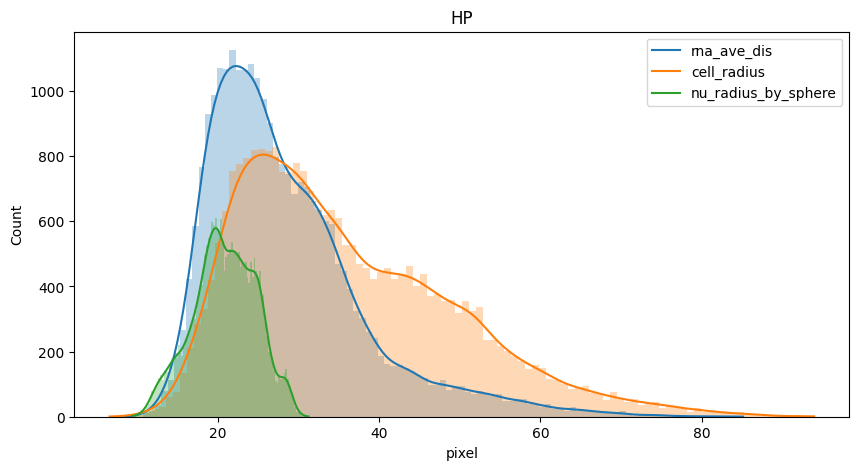

In [180]:
os.makedirs(os.path.join(workdir, 'subcellular_analysis'), exist_ok=True)

plt.figure(figsize=(10, 5))
sns.histplot(cell_info['rna_ave_dis'], bins=100, alpha=0.3, kde=True, edgecolor=None)
sns.histplot(cell_info['cell_radius'], bins=100, alpha=0.3, kde=True, edgecolor=None)
# sns.histplot([np.cbrt((3 * volume) / (4 * np.pi)) for volume in cell_info['cell_volume']], bins=100, alpha=0.3, kde=True, edgecolor=None)
sns.histplot([np.cbrt((3 * volume) / (4 * np.pi)) for volume in cell_info['nu_volume']], bins=100, alpha=0.3, kde=True, edgecolor=None)
plt.legend(['rna_ave_dis', 'cell_radius', 'nu_radius_by_sphere',])
plt.title(workdir.split('_')[-3])
plt.xlabel('pixel')
plt.savefig(os.path.join(workdir, 'subcellular_analysis', 'overview_of_key_parameters.png'), bbox_inches = 'tight')

## save info

In [181]:
rna_df.to_csv(os.path.join(workdir, 'mapped_genes_processed.csv'))
cell_info.to_csv(os.path.join(workdir, 'cell_info.csv'))

# gene/cell type specific analysis

In [478]:
rna_df = pd.read_csv(os.path.join(workdir, 'mapped_genes_processed.csv'), index_col=0)
cell_info = pd.read_csv(os.path.join(workdir, 'cell_info.csv'), index_col=0)

In [1477]:
# CTX
type_of_interest = [ 
    'Ex-L2/3',
    'Ex-L4',
    'Ex-L5',
    'Ex-L6a',
    'Ex-L6b',

    'In-Vip', 
    'In-Sst',
    'In-Pvalb', 

    'Astrocyte', 
    'Microglia', 
    'Oligodendrocyte', 
    ]

In [807]:
# HT
type_of_interest = [
    "Ex-1",
    "Ex-2-Rorb",
    "In-Sst",
    "In-Pvalb",
    "Astrocyte",
    "Microglia",
    "Oligodendrocyte",
    "Pmch+",
]

In [935]:
# HP
type_of_interest = [
    "Ex-1",
    "Ex-2-CA3",
    "Ex-3-CA1",
    "Ex-4-DG",
    "Ex-5-thalamus",
    "Ex-6-MH",
    "In-Pvalb",
    "In-Sst",
    "Astrocyte",
    "Microglia",
    "Oligodendrocyte",
]

In [979]:
# TH
type_of_interest = [
    "Ex",

    "In-Pvalb",
    "In-Sst",
    "In-Vip",

    "Astrocyte",
    "Microglia",
    "Oligodendrocyte",
]

## statistic analysis

In [980]:
from scipy.spatial.distance import euclidean


cell_thre = 5
rna_thre = 5

mrna_dis = dict()
mrna_dis_ratio = dict()
mrna_in_nu_fraction = dict()
mrna_polar = dict()

valid_index = []

for cell_type in tqdm(type_of_interest):
    tmp_cell = cell_info[cell_info['type']==cell_type]

    dis = []
    dis_ratio = []
    in_nu_fraction = []
    tmp_index = []
    polar = []

    for gene in gene_order_list:
        tmp = rna_df[rna_df['Gene'] == gene]
        
        dis_one_cell = []
        dis_ratio_one_cell = []
        in_nu_fractio_one_cell = []
        polar_one_cell = []

        for index in tmp_cell.index:
            centroid = tmp_cell[['ce_z_in_pix','ce_x_in_pix','ce_y_in_pix']].loc[index].values
            cell_radius = tmp_cell['cell_radius'].loc[index]
            tmp_rnas = tmp[tmp['Cell Index']==index]
            
            if len(tmp_rnas) < rna_thre:
                continue
            else:
                tmp_index.append(index)
                dis_rna = [euclidean(centroid, point) for point in tmp_rnas[['z_in_pix','x_in_pix','y_in_pix']].values]
                dis_one_cell.append(np.mean(dis_rna))
                dis_ratio_one_cell.append(np.mean(dis_rna) / cell_radius)
                in_nu_fractio_one_cell.append(len(tmp_rnas[tmp_rnas['in_nu']==True]) / len(tmp_rnas))
                polar_one_cell.append(euclidean(centroid, np.mean(tmp_rnas[['z_in_pix','x_in_pix','y_in_pix']].values, axis=0)))

        if len(dis_one_cell) < cell_thre:
            dis.append(np.nan)
            dis_ratio.append(np.nan) 
            in_nu_fraction.append(np.nan)
            polar.append(np.nan)
            
        else:
            valid_index += tmp_index
            dis.append(np.mean(dis_one_cell))
            dis_ratio.append(np.mean(dis_ratio_one_cell))
            in_nu_fraction.append(np.mean(in_nu_fractio_one_cell))
            polar.append(np.mean(polar_one_cell))
            

    mrna_dis[cell_type] = dis
    mrna_dis_ratio[cell_type] = dis_ratio
    mrna_in_nu_fraction[cell_type] = in_nu_fraction
    mrna_polar[cell_type] = polar

valid_index = sorted(list(set(valid_index)))

100%|██████████| 7/7 [01:33<00:00, 13.41s/it]


### visulization: heatmap

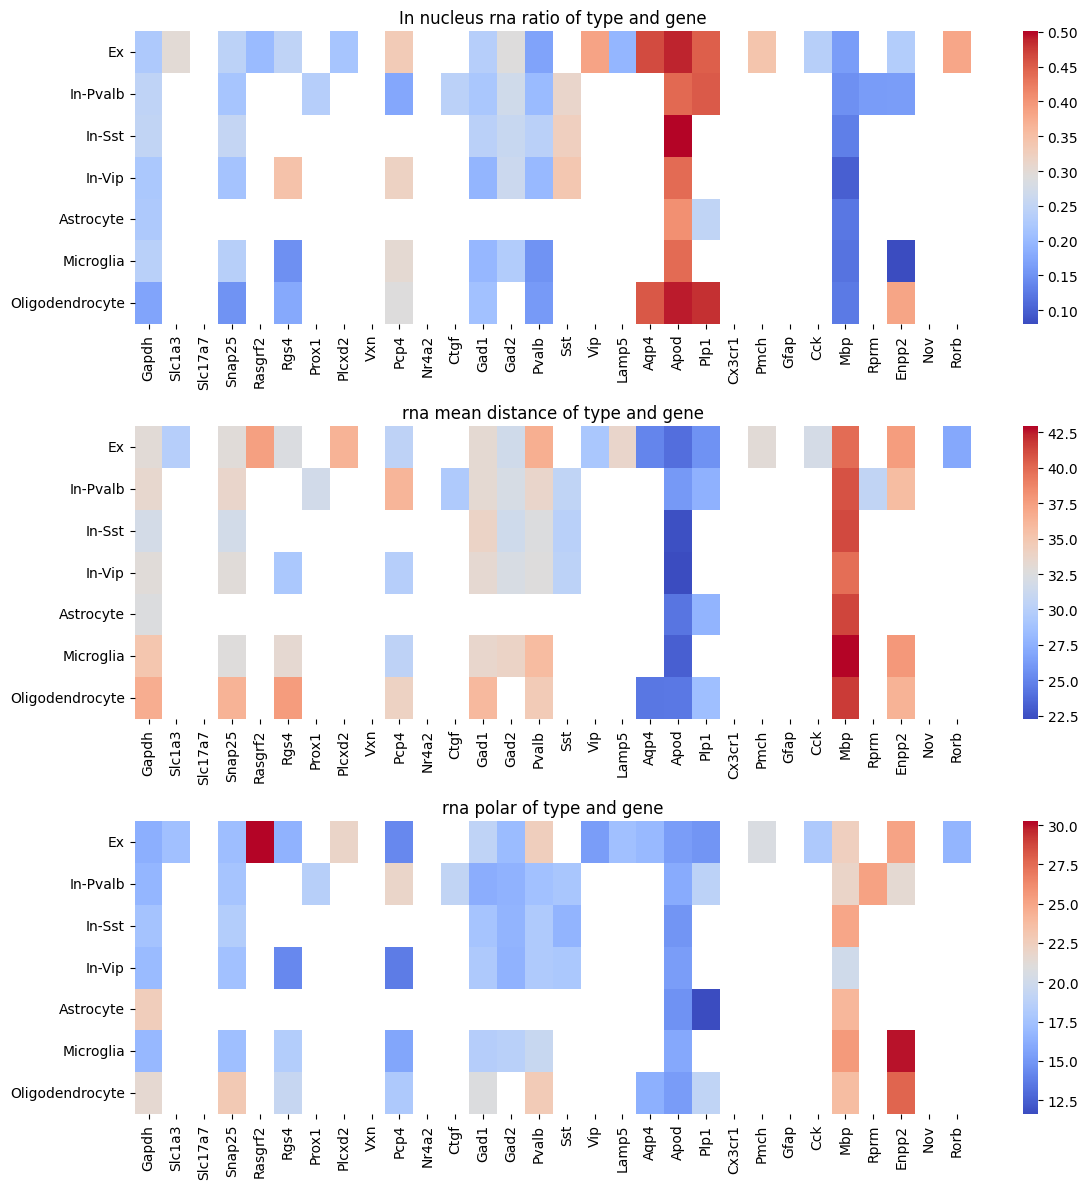

In [981]:
fig, ax = plt.subplots(nrows=3, figsize=(12,12))
in_nu_for_heat = pd.DataFrame(mrna_in_nu_fraction)
in_nu_for_heat.index = gene_order_list
# in_nu_for_heat = in_nu_for_heat.loc[gene_list]
sns.heatmap(in_nu_for_heat.T, ax=ax[0], cmap='coolwarm')
ax[0].set_title('In nucleus rna ratio of type and gene')

# mrna_dis_ratio_for_heat = pd.DataFrame(mrna_dis_ratio)
# mrna_dis_ratio_for_heat.index = rna_df['Gene'].unique()
# sns.heatmap(mrna_dis_ratio_for_heat.T, ax=ax[1], cmap='coolwarm')
# ax[1].set_title('rna_mean_distance/cell_radius of type and gene')

mrna_dis_for_heat = pd.DataFrame(mrna_dis)
mrna_dis_for_heat.index = gene_order_list
# mrna_dis_for_heat = mrna_dis_for_heat.loc[gene_list]
sns.heatmap(mrna_dis_for_heat.T, ax=ax[1], cmap='coolwarm')
ax[1].set_title('rna mean distance of type and gene')

mrna_polar_for_heat = pd.DataFrame(mrna_polar)
mrna_polar_for_heat.index = gene_order_list
# mrna_polar_for_heat = mrna_polar_for_heat.loc[gene_list]
sns.heatmap(mrna_polar_for_heat.T, ax=ax[2], cmap='coolwarm')
ax[2].set_title('rna polar of type and gene')

plt.tight_layout()
plt.show()

### visualization: histplot

Text(0.5, 1.0, 'in_nu')

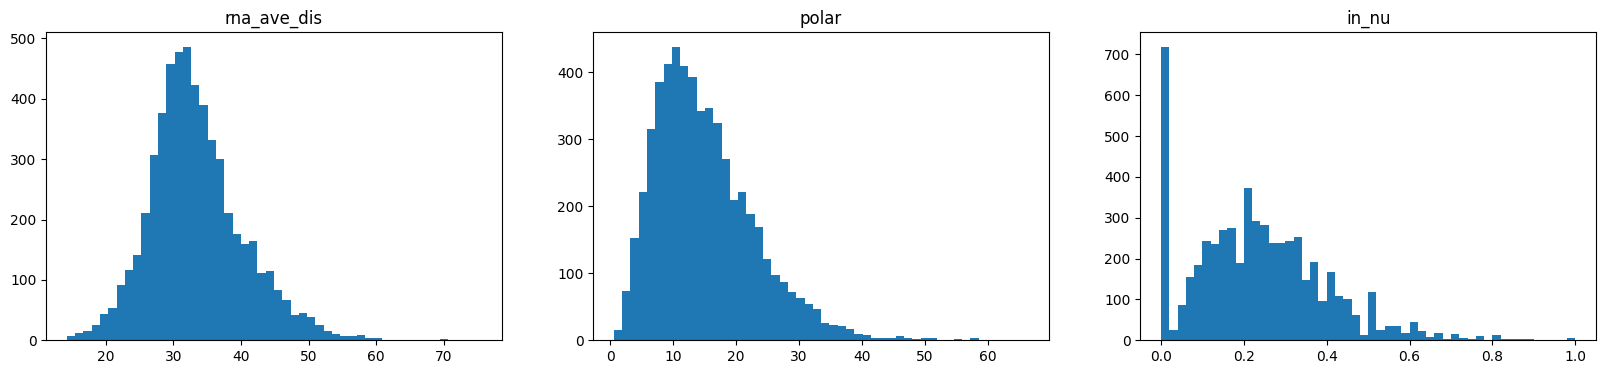

In [982]:
bins = 50
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20,4))
ax[0].hist(cell_info['rna_ave_dis'], bins=bins)
ax[0].set_title('rna_ave_dis')
ax[1].hist(cell_info['polar'], bins=bins)
ax[1].set_title('polar')
ax[2].hist(cell_info['in_nu'], bins=bins)
ax[2].set_title('in_nu')

## Single cell projection 

In [266]:
workdir = r'./processed/20230710_PRISM3D_mousebrain_HP_rm_doublet'

In [267]:
cell_info = pd.read_csv(os.path.join(workdir, 'cell_Info.csv'), index_col=0)
rna_df = pd.read_csv(os.path.join(workdir, 'mapped_genes_processed.csv'), index_col=0)

In [268]:
import tifffile

with tifffile.TiffFile(os.path.join(workdir, 'cell_segment', 'dapi_predict.tif')) as tif:
    dapi_predict = np.sign(tif.asarray()).astype(np.uint8)
with tifffile.TiffFile(os.path.join(workdir, 'cell_segment', 'cell_convex.tif')) as tif:
    cell_convex = np.sign(tif.asarray()).astype(np.uint8)

In [269]:
type_of_interest = [line.strip() for line in open(os.path.join(workdir, 'cell_typing', 'annotated_subtype.txt'), 'r')]
cell_info['subtype'] = pd.Categorical(cell_info['subtype'], categories=type_of_interest, ordered=True)

In [270]:
from scipy.ndimage import zoom
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tifffile")


# valid_cells = cell_info.loc[valid_index]
valid_cells = cell_info.copy()
for _, tmp_cell_type in enumerate(type_of_interest):
    out_path = os.path.join(workdir, 'subcellular_analysis', 'single_cell_projection_in_out', f'{_+1}_{tmp_cell_type}')
    os.makedirs(out_path, exist_ok=True)
    for index in tqdm(valid_cells[valid_cells['subtype']==tmp_cell_type].index, desc=tmp_cell_type):
        # if len(rna_df[rna_df['Cell Index']==index])<10:
        #     continue
        centroid = valid_cells[['ce_z_in_pix','ce_x_in_pix','ce_y_in_pix']].loc[index].values
        cell_rnas = rna_df[rna_df['Cell Index']==index]
        min_pos = np.min(cell_rnas[['z_in_pix','x_in_pix','y_in_pix']].values, axis=0)
        max_pos = np.max(cell_rnas[['z_in_pix','x_in_pix','y_in_pix']].values, axis=0)

        shape = max_pos - min_pos + 40
        shape=np.uint16(shape)
        cell_array = np.zeros(shape=shape, dtype=np.uint8)


        nucleus_array = dapi_predict[
            int((min_pos[0]-20)//3.36): int((max_pos[0]+20)//3.36), 
            int(min_pos[1] - 20): int(max_pos[1] + 20), 
            int(min_pos[2] - 20): int(max_pos[2] + 20)
            ].astype(np.uint8)
        
        convex_array = cell_convex[
            int((min_pos[0]-20)//3.36): int((max_pos[0]+20)//3.36), 
            int(min_pos[1] - 20): int(max_pos[1] + 20), 
            int(min_pos[2] - 20): int(max_pos[2] + 20)
            ].astype(np.uint8)

        zoom_factor = (shape[0] / (int((max_pos[0]+20)//3.36) - int((min_pos[0]-20)//3.36)), 1, 1)
        nucleus_array = zoom(nucleus_array, zoom_factor, order=3)
        convex_array = zoom(convex_array, zoom_factor, order=3)
        
        centroid = centroid - min_pos + 20
        centroid[0] = int(centroid[0])
        centroid = np.uint16(centroid)
        
        try:
            cell_array[centroid[0], centroid[1], centroid[2]] = 50
        except:
            print(f'cell_{index} centroid out of bound.')
            # continue

        for _, gene in enumerate(gene_order_list):
            gene_rnas = cell_rnas[cell_rnas['Gene'] == gene][['z_in_pix','x_in_pix','y_in_pix']].values
            in_nu = cell_rnas[cell_rnas['Gene'] == gene][['in_nu']].values
            for pos, in_nu_tmp in zip(gene_rnas, in_nu):
                pos = np.uint16(pos-min_pos+20)
                if in_nu_tmp[0]:
                    cell_array[pos[0], pos[1], pos[2]] = _ + 1
                else:
                    cell_array[pos[0], pos[1], pos[2]] = _ + 51
        
        tifffile.imwrite(os.path.join(out_path, f'{index},{len(cell_rnas)},1.tif'), cell_array)
        tifffile.imwrite(os.path.join(out_path, f'{index},{len(cell_rnas)},2.tif'), nucleus_array)
        tifffile.imwrite(os.path.join(out_path, f'{index},{len(cell_rnas)},3.tif'), convex_array)

Ex-1:   0%|          | 0/551 [00:00<?, ?it/s]

Ex-1:  47%|████▋     | 261/551 [01:46<00:49,  5.81it/s]

cell_16694 centroid out of bound.


Ex-3-Rorb+:  61%|██████▏   | 550/897 [04:05<03:49,  1.51it/s]

cell_26132 centroid out of bound.


Ex-4-Rprm+:  84%|████████▍ | 717/854 [04:23<00:42,  3.22it/s]

cell_29040 centroid out of bound.


Ex-5-other:  82%|████████▏ | 1366/1673 [11:21<03:20,  1.53it/s]

cell_27781 centroid out of bound.


Ex-CA1:  91%|█████████▏| 1506/1650 [10:37<00:57,  2.49it/s]

cell_29469 centroid out of bound.


Ex-CA1:  98%|█████████▊| 1613/1650 [11:22<00:19,  1.92it/s]

cell_35067 centroid out of bound.


Ex-DG:   6%|▋         | 159/2529 [01:40<18:01,  2.19it/s]

cell_8750 centroid out of bound.


Ex-DG:  12%|█▏        | 298/2529 [02:32<12:11,  3.05it/s]

cell_11868 centroid out of bound.


Ex-DG:  60%|██████    | 1529/2529 [07:42<03:09,  5.28it/s]

cell_21651 centroid out of bound.


Ex-DG:  91%|█████████ | 2298/2529 [11:20<01:12,  3.19it/s]

cell_29621 centroid out of bound.


Ex-MH:  10%|▉         | 33/337 [00:19<02:04,  2.44it/s]

cell_9412 centroid out of bound.


Ex-MH:  66%|██████▌   | 221/337 [01:21<00:40,  2.86it/s]

cell_32345 centroid out of bound.


Ex-thalamus:   6%|▋         | 140/2208 [01:24<14:50,  2.32it/s]

cell_8606 centroid out of bound.


Ex-thalamus:  54%|█████▎    | 1185/2208 [09:34<05:17,  3.22it/s]

cell_25816 centroid out of bound.


Ex-thalamus:  70%|██████▉   | 1541/2208 [13:32<03:53,  2.86it/s]

cell_30619 centroid out of bound.


Ex-thalamus:  75%|███████▍  | 1655/2208 [14:06<04:16,  2.16it/s]

cell_33733 centroid out of bound.


Ex-thalamus:  98%|█████████▊| 2155/2208 [18:40<00:47,  1.12it/s]

cell_37680 centroid out of bound.


In-Lamp5:  10%|█         | 172/1644 [01:47<24:41,  1.01s/it]

cell_5224 centroid out of bound.


In-Lamp5:  69%|██████▊   | 1129/1644 [09:55<05:08,  1.67it/s]

cell_26397 centroid out of bound.


In-Lamp5:  85%|████████▍ | 1391/1644 [12:49<01:16,  3.31it/s]

cell_32937 centroid out of bound.


In-Pvalb:  27%|██▋       | 266/982 [03:19<03:54,  3.05it/s]

cell_9372 centroid out of bound.


In-Pvalb:  44%|████▍     | 431/982 [04:38<02:41,  3.41it/s]

cell_19722 centroid out of bound.


In-Sst:  31%|███       | 240/773 [02:59<06:22,  1.39it/s]

cell_10507 centroid out of bound.


In-other:  14%|█▍        | 70/509 [00:48<04:28,  1.64it/s]

cell_6395 centroid out of bound.


In-other:  86%|████████▋ | 440/509 [03:16<00:19,  3.60it/s]

cell_30873 centroid out of bound.


Glial-Astrocyte:   1%|          | 9/1293 [00:03<07:36,  2.81it/s]

cell_345 centroid out of bound.


Glial-Astrocyte:  16%|█▌        | 208/1293 [02:04<10:17,  1.76it/s]

cell_6190 centroid out of bound.


Glial-Astrocyte:  19%|█▉        | 246/1293 [02:34<11:52,  1.47it/s]

cell_7132 centroid out of bound.


Glial-Astrocyte:  52%|█████▏    | 675/1293 [05:47<03:32,  2.91it/s]

cell_17237 centroid out of bound.


Glial-Microglia:  28%|██▊       | 402/1425 [04:04<14:34,  1.17it/s]

cell_7640 centroid out of bound.


Glial-Microglia:  86%|████████▌ | 1229/1425 [09:34<01:45,  1.86it/s]

cell_29316 centroid out of bound.


Glial-Microglia:  87%|████████▋ | 1243/1425 [09:39<01:03,  2.87it/s]

cell_29570 centroid out of bound.


Glial-Oligodendrocyte:  28%|██▊       | 485/1724 [03:16<07:15,  2.84it/s]

cell_8480 centroid out of bound.


Glial-Oligodendrocyte: 100%|██████████| 1724/1724 [11:33<00:00,  2.48it/s]


# In out exp matrix

In [1]:
workdir = './dataset/0704_CTX'

In [4]:
rna_df = pd.read_csv(os.path.join(workdir, 'mapped_genes_processed.csv'), index_col=0)
cell_info = pd.read_csv(os.path.join(workdir, 'Cell_info.csv'), index_col=0)

In [1372]:
import scanpy as sc


def matrix_to_normalize_adata(rna_df, cell_info):
    match_df = rna_df.copy()
    match_df['Count'] = np.ones(len(match_df))
    match_df_group = match_df[['Cell Index','Gene','Count']].groupby(['Cell Index','Gene']).count()
    matrix = match_df_group.unstack().fillna(0)
    matrix.columns = matrix.columns.droplevel()
    matrix = matrix[matrix.index.isin(cell_info.index)]

    adata = sc.AnnData(matrix)
    adata.obs.index = [int(_) for _ in adata.obs.index]
    adata.raw = adata.copy()

    sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True)
    adata.obs.type = cell_info.type.loc[adata.obs.index]

    adata.X = adata.raw.X.copy()

    # Normalization scaling
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.log1p(adata)

    # Scale data to unit variance and zero mean
    # sc.pp.regress_out(adata, ["total_counts"])
    # sc.pp.scale(in_adata)
    return adata

In [1373]:
in_adata = matrix_to_normalize_adata(rna_df[rna_df['in_nu'] == True], cell_info)
ou_adata = matrix_to_normalize_adata(rna_df[rna_df['in_nu'] == False], cell_info)

In [1429]:
import matplotlib.pyplot as plt
from scipy import stats


def adjust_regress(x, y):
    # Perform linear regression
    x_adjust = []
    y_adjust = []
    for i in range(len(x)):
        x_tmp = x[i]
        y_tmp = y[i]
        if 0 < (x_tmp ** 2 + y_tmp ** 2) ** (1/2) < 1005:
            x_adjust.append(x_tmp)
            y_adjust.append(y_tmp)
    x_adjust = np.array(x_adjust)
    y_adjust = np.array(y_adjust)
    ## without intercept
    slope = np.linalg.lstsq(x_adjust[:, np.newaxis], y_adjust, rcond=None)[0][0]
    intercept = 0
    
    # ## with intercept
    # slope, intercept, r_value, p_value, std_err = stats.linregress(x_adjust, y_adjust)
    # line_x = np.linspace(min(x), max(x), 100)
    # line_y = slope * line_x + intercept
    return slope, intercept


def draw_with_regress(x, y, slope, intercept, categories, cell_type, percentile=80, cmap='plasma', ax=None, show=False, ):
    gene_num = len(categories)
    # Choose a continuous colormap
    cmap = plt.cm.get_cmap(cmap, gene_num)  # Replace 'viridis' with your preferred cmap
    # Generate a list of 30 colors from the colormap
    colors = cmap(np.linspace(0, 1, gene_num))
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    else:
        ax=ax
        
    ylim_max = max(max(y) + 0.1, (max(x) + 0.1) / np.tan(np.radians(45)) * slope)
    xlim_max = max((max(y) + 0.1) * np.tan(np.radians(45)) / slope, max(x) + 0.1)

    # Prepare regression line data    
    line_x = np.linspace(0, xlim_max, 100)
    line_y = slope * line_x + intercept

    # Plot the regression line
    ax.plot(line_x, line_y, color='red')

    # plot scatter of gene
    for j in range(gene_num):
        category = categories[j]
        x_cat = [x[i] for i in range(len(x)) if categories[i] == category]
        y_cat = [y[i] for i in range(len(y)) if categories[i] == category]
        if x_cat[0] > np.percentile(x, percentile) or y_cat[0] > np.percentile(y, percentile):
            ax.scatter(x_cat, y_cat, label=category, color=colors[j])
            ax.text(x_cat[0], y_cat[0], category)
        else:
            ax.scatter(x_cat, y_cat, label=category, color='gray')

    ## set x and y range
    ax.set_xlim(0, xlim_max)
    ax.set_ylim(0, ylim_max)

    ax.set_title(f'{cell_type}')
    ax.set_xlabel('in_nucleus')
    ax.set_ylabel('out_nucleus')
    # plt.legend()
    if show:
        plt.show()

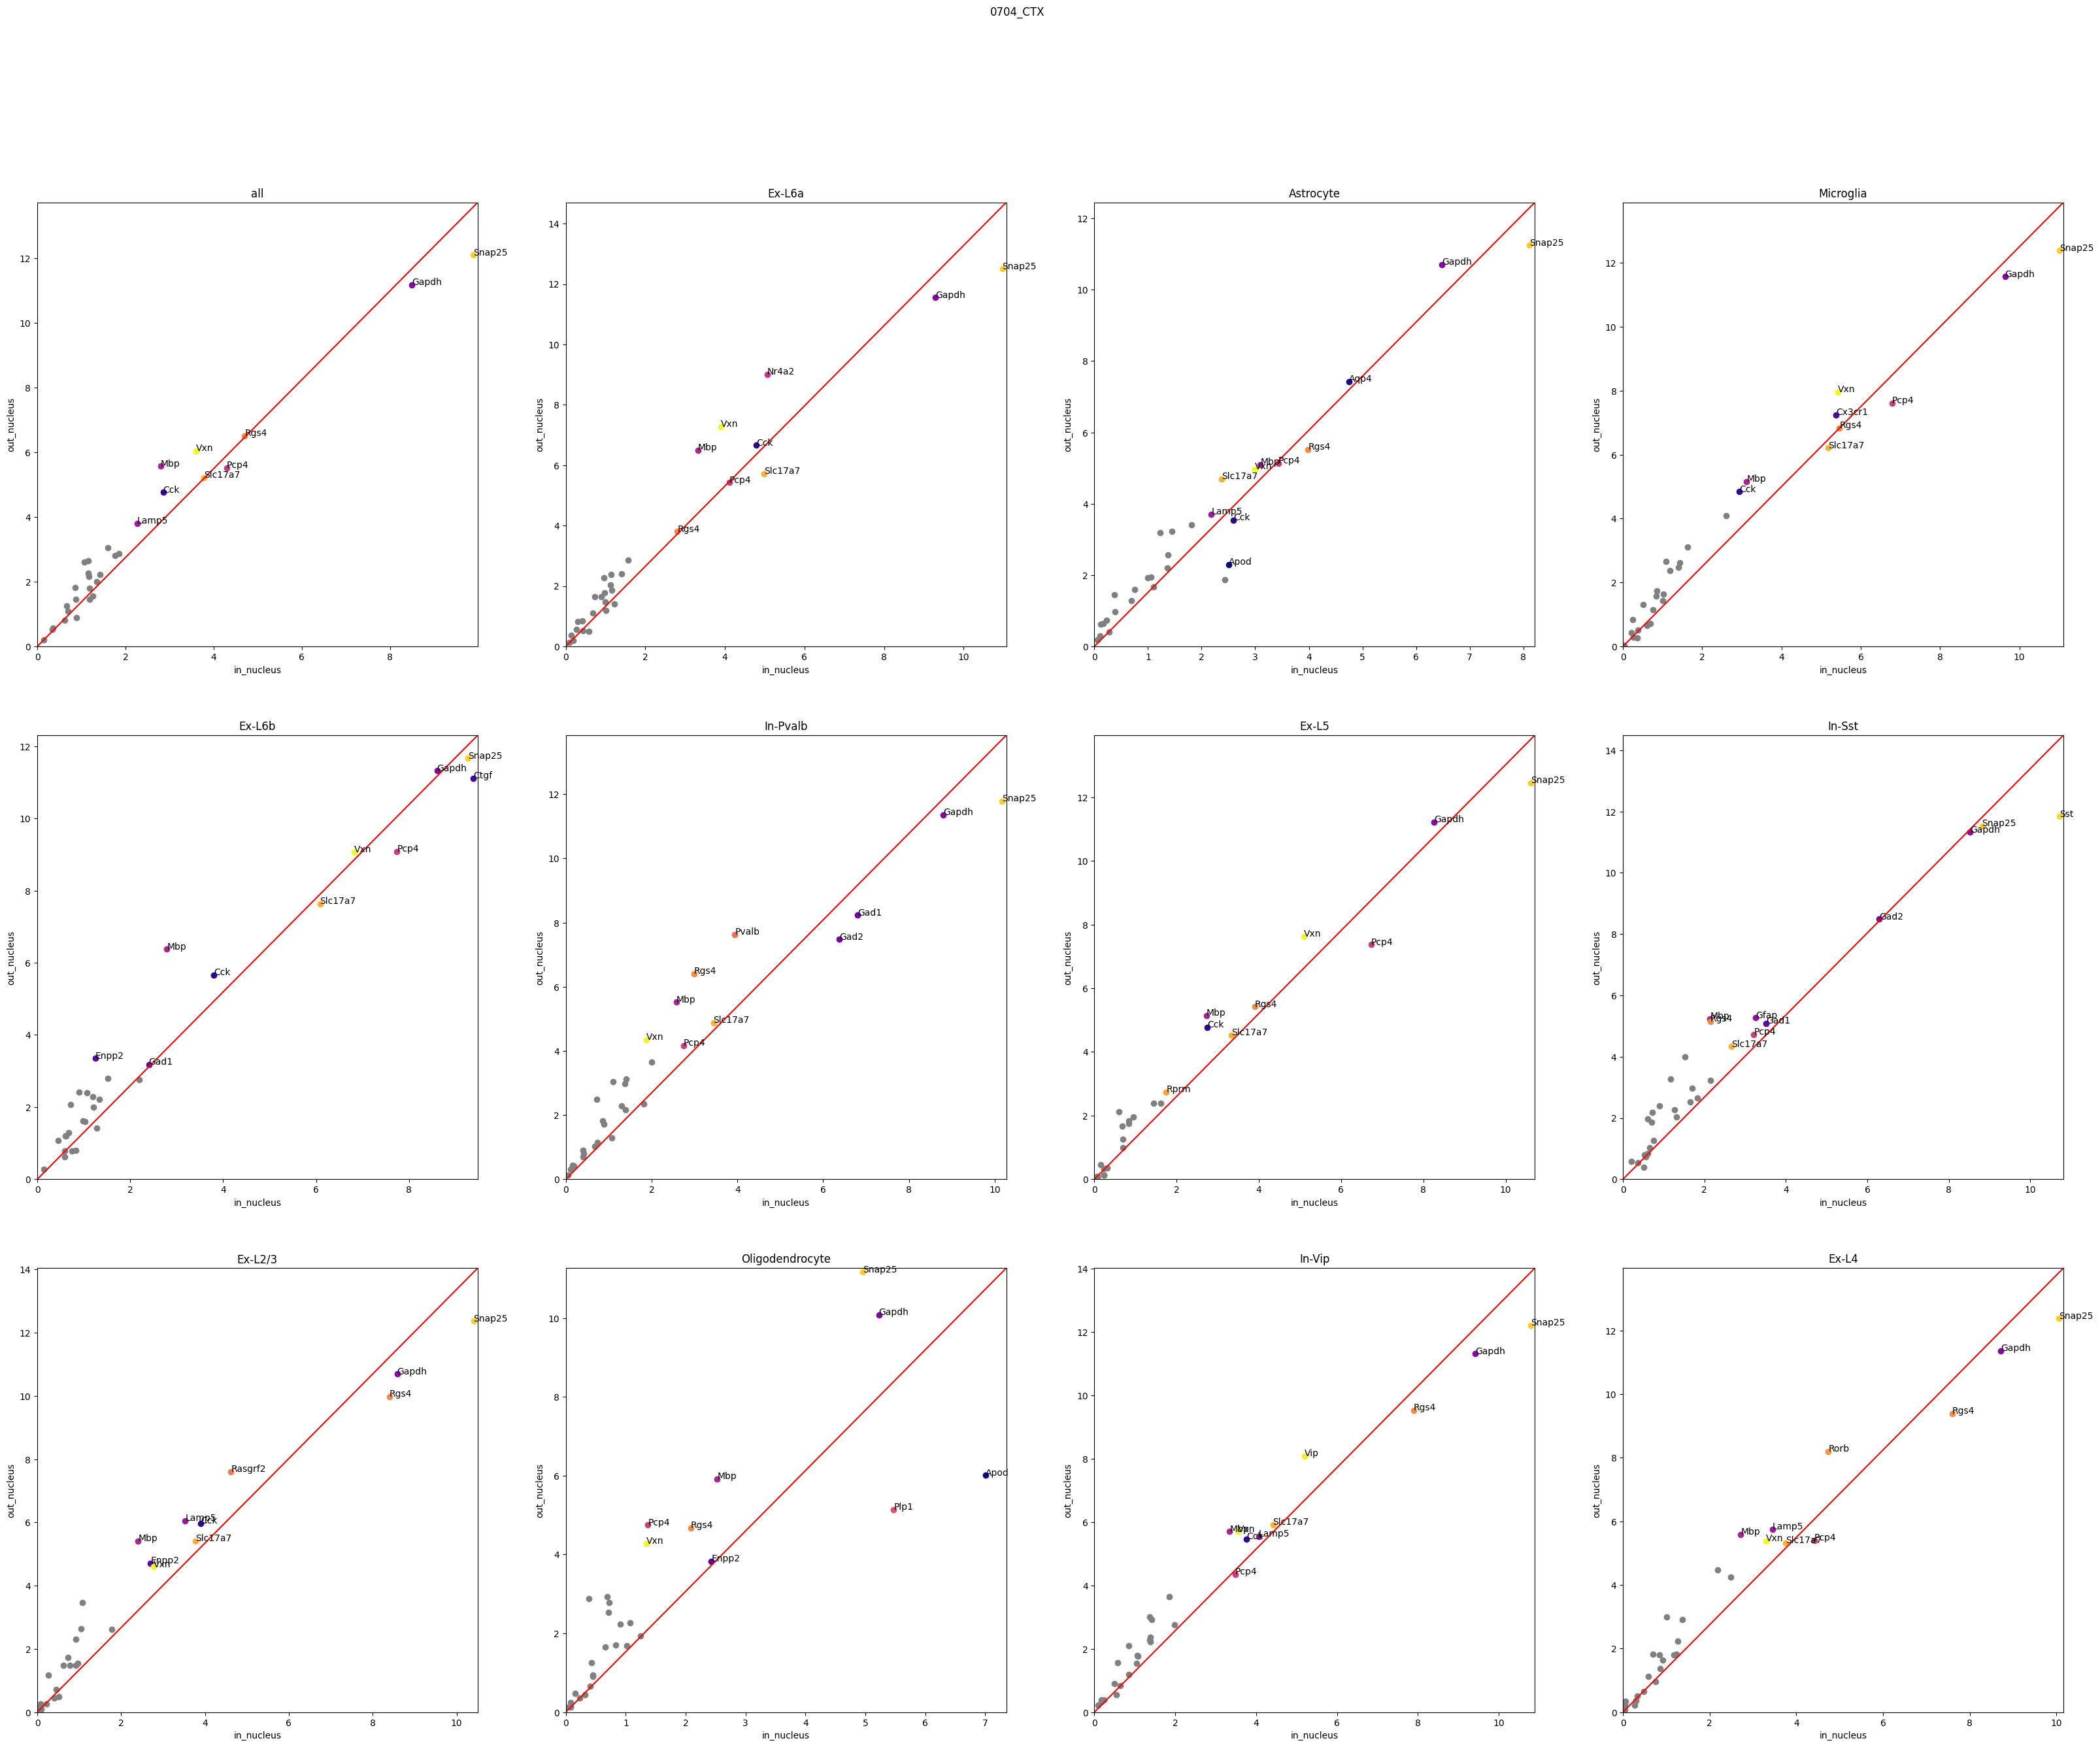

In [1430]:
cell_type_list = ['all'] + [_ for _ in cell_info.type.unique()]

nrows = int(len(cell_type_list)**(1/2))
ncols = - int( - len(cell_type_list) / nrows)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 10, nrows * 10))
for _, cell_type in enumerate(cell_type_list):
    ax_tmp = ax if ncols==1 and nrows==1 else ax[_] if ncols==1 else ax[_//ncols][_%ncols]
    if cell_type == 'all':
        x = in_adata.X.mean(axis=0)
        y = ou_adata.X.mean(axis=0)
        # plt.legend()
    else:
        x = in_adata[in_adata.obs.type == cell_type].X.mean(axis=0)
        y = ou_adata[ou_adata.obs.type == cell_type].X.mean(axis=0)
    # ax_tmp = ax
    slope, intercept = adjust_regress(x, y)
    draw_with_regress(x, y, slope, intercept, cell_type=cell_type, categories=in_adata.var_names, percentile=70, cmap='plasma', show=False, ax=ax_tmp)

plt.suptitle(workdir.split('/')[-1])
# plt.tight_layout()
plt.show()

# In out Roe

In [1412]:
cell_type_list = [_ for _ in cell_info.type.unique()]
Roe = dict()
for cell_type in cell_type_list:
    Roe[cell_type] = dict()
    rna_by_nu = rna_df[rna_df['in_nu'] == nu]
    
    for nu in [True, False]:
        index = cell_info[cell_info['type']==cell_type].index
        rna_by_type = rna_df[rna_df['Cell Index'].isin(index)]
        Roe[cell_type][nu] = []
        
        for gene in gene_order_list:
            rna_by_gene = rna_df[rna_df['Gene']==gene]
            rna_by_gene_type = rna_by_type[rna_by_type['Gene']==gene]

            rna_by_gene_type_nu = rna_by_gene_type[rna_by_gene_type['in_nu']==nu]
            rna_by_gene_type_nu_expect = len(rna_by_gene) * len(rna_by_type) * len(rna_by_nu) / len(rna_df)**2

            Roe[cell_type][nu].append(len(rna_by_gene_type_nu) / rna_by_gene_type_nu_expect)
        
    Roe[cell_type] = pd.DataFrame(Roe[cell_type])
    Roe[cell_type].index = gene_order_list

In [1667]:
cell_type_list

['all',
 'Ex-L6a',
 'Astrocyte',
 'Microglia',
 'Ex-L6b',
 'In-Pvalb',
 'Ex-L5',
 'In-Sst',
 'Ex-L2/3',
 'Oligodendrocyte',
 'In-Vip',
 'Ex-L4']

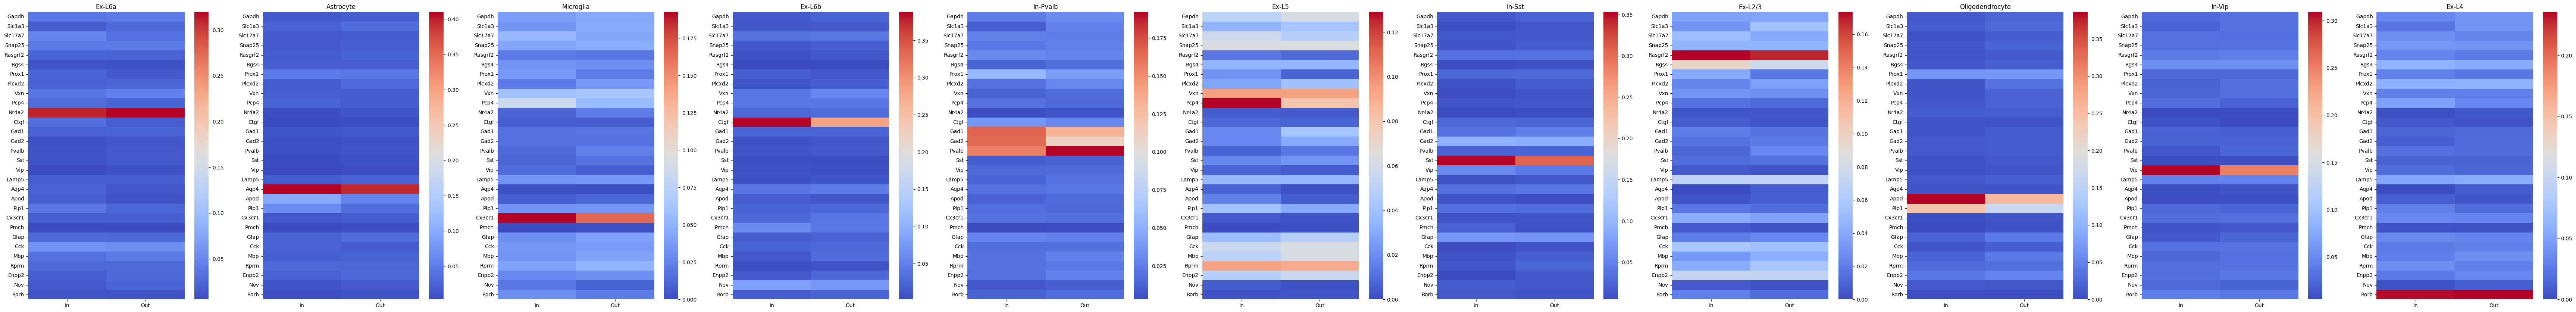

In [1677]:
import seaborn as sns

fig, ax = plt.subplots(ncols=len(cell_type_list[1:]), nrows=1, figsize=(len(cell_type_list[1:]) * 8, 10))

for _, type_map in enumerate(cell_type_list[1: ]):    
    data = Roe[type_map].copy()
    data = data / np.sum(data, axis=0) 
    # data = (data.T / np.sum(data, axis=1)).T
    data.columns = ['In', 'Out']

    sns.heatmap(data, cmap='coolwarm', ax=ax[_])
    ax[_].set_title(type_map)
    

plt.savefig(os.path.join(workdir, 'figures', f'3d_Roe_cut_by_celltype.pdf'), bbox_inches = 'tight')
# plt.close()

In [1614]:
Enrich_df = pd.DataFrame()
In_df = pd.DataFrame()
Out_df = pd.DataFrame()

for cell_type in type_of_interest:
# for cell_type in Roe.keys():
    data = Roe[cell_type].copy()
    Enrich_df[cell_type] = np.sum(data, axis=1)
    data = data / np.sum(data, axis=0) 
    data = (data.T / np.sum(data, axis=1)).T
    # data = data * 100
    data.columns = ['In', 'Out']

    In_df[cell_type] = data['In']
    Out_df[cell_type] = data['Out']

Enrich_df.index = data.index
In_df.index = data.index
Out_df.index = data.index

Enrich_df = Enrich_df.T
In_df = In_df.T
Out_df = Out_df.T

## Roe shown as dotplot

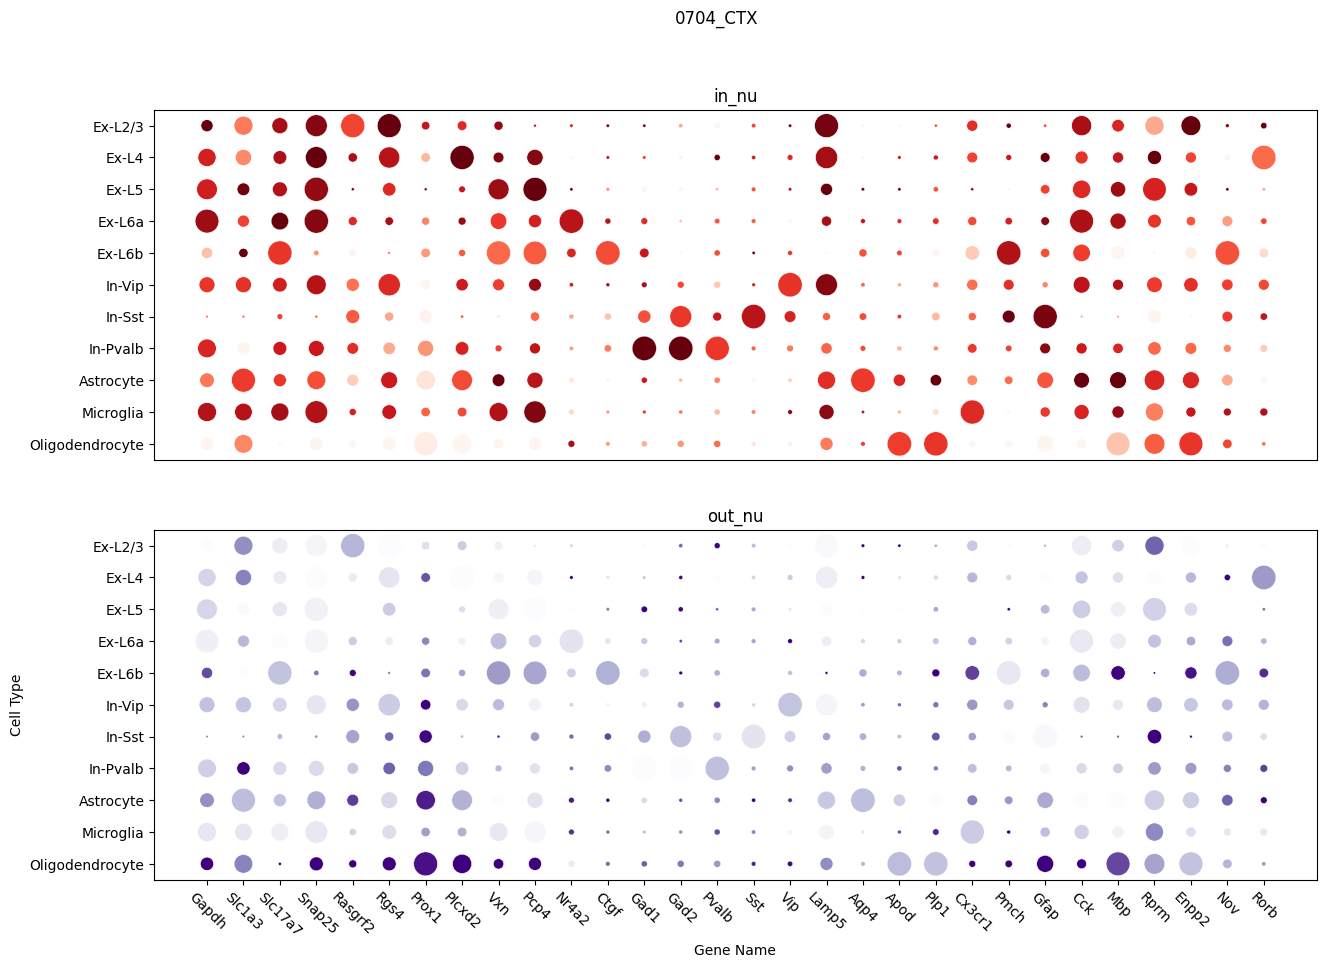

In [1615]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create the dot plot
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(15, 10))

# We need to iterate over each cell type to plot
for gene in Enrich_df.columns:
    sns.scatterplot(x=[gene] * len(Enrich_df), y=Enrich_df.index, 
                    size=Enrich_df[gene], sizes=(5, 300), 
                    hue=In_df[gene], ax=ax[0],
                    palette='Reds', legend=None)
    
ax[0].set_xticks([])
ax[0].set_title('in_nu')

# We need to iterate over each cell type to plot
for gene in Enrich_df.columns:
    sns.scatterplot(x=[gene] * len(Enrich_df), y=Enrich_df.index, 
                    size=Enrich_df[gene], sizes=(5, 300), 
                    hue=Out_df[gene], ax=ax[1],
                    palette='Purples', legend=None)

ax[1].set_title('out_nu')

plt.ylabel('Cell Type')
plt.xlabel('Gene Name')
plt.xticks(rotation=-45)

plt.suptitle(workdir.split('/')[-1])
# plt.legend(title='Expression Level', bbox_to_anchor=(1.05, 1), loc=2)
plt.show()
# plt.savefig(r'E:\TMC\subcellular_analysis\dataset\0704_CTX\figures\nucleus_distribution_dotplot.pdf', bbox_inches = 'tight')


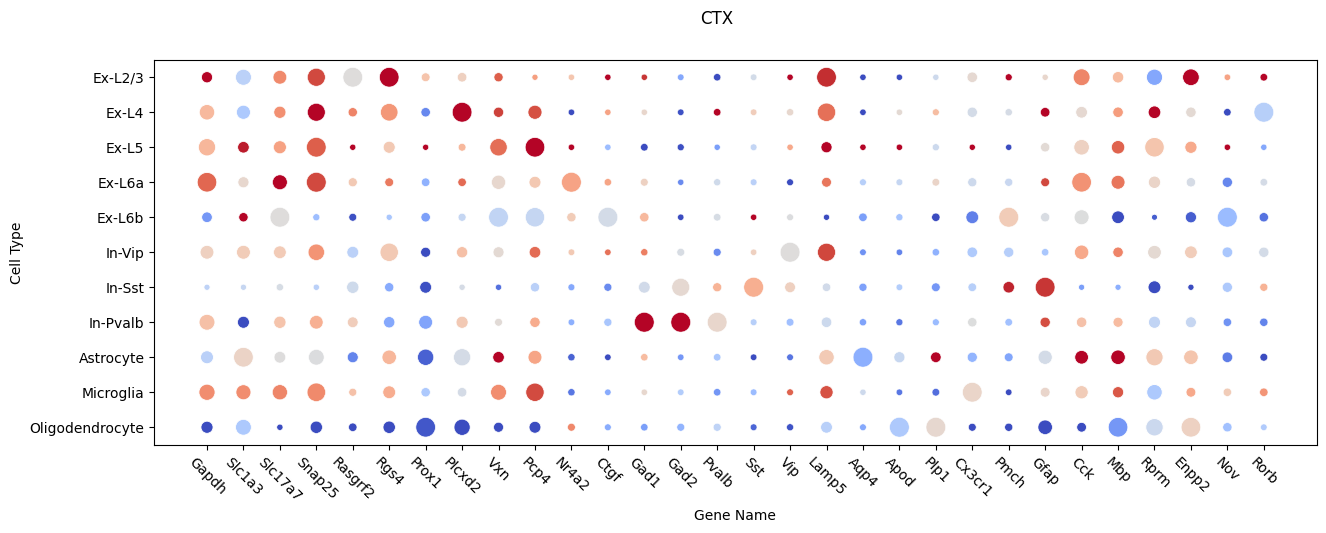

In [1589]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create the dot plot
fig, ax = plt.subplots(figsize=(15, 5))

# We need to iterate over each cell type to plot
for gene in Enrich_df.columns:
    sns.scatterplot(x=[gene] * len(Enrich_df), y=Enrich_df.index, 
                    size=Enrich_df[gene], sizes=(20, 200), 
                    hue=In_df[gene] / Out_df[gene],
                    palette='coolwarm', legend=None)

plt.ylabel('Cell Type')
plt.xlabel('Gene Name')
plt.xticks(rotation=-45)

plt.suptitle('CTX')
# plt.legend(title='Expression Level', bbox_to_anchor=(1.05, 1), loc=2)
plt.show()
# plt.savefig(r'E:\TMC\subcellular_analysis\dataset\0704_CTX\figures\nucleus_distribution_dotplot_combine.pdf', bbox_inches = 'tight')


# gene neighborhood analysis

In [446]:
cell_info = pd.read_csv(os.path.join(workdir, 'Cell_Info.csv'), index_col=0)
rna_df = pd.read_csv(os.path.join(workdir, 'mapped_genes_processed.csv'), index_col=0)

In [1649]:
def ave_with_na(x, y, weight_x=1, weight_y=1):
    if x == np.nan:
        return y
    elif y ==np.nan:
        return x
    else:
        return (x * weight_x + y * weight_y) / (weight_x + weight_y)

In [1683]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

type_relationships = np.zeros((len(gene_order_list), len(gene_order_list)))
weight = np.zeros((len(gene_order_list), len(gene_order_list)))

for cell in tqdm(cell_info.sample(100).index):
    data = rna_df[rna_df['Cell Index']==cell]
    data.index = [int(_) for _ in range(len(data))]
    points = data[['x_in_pix', 'y_in_pix', 'z_in_pix', ]]
    distances = squareform(pdist(points, 'euclidean'))

    # Alternatively, if you want to focus on type relationships
    # You can transform the distances based on types (e.g., average distance between types)
    
    for i, type1 in enumerate(gene_order_list):
        for j, type2 in enumerate(gene_order_list):
            type1_indices = data[data['Gene']==type1].index
            type2_indices = data[data['Gene']==type2].index
            avg_distance = np.nanmean([distances[ind1, ind2] for ind1 in type1_indices for ind2 in type2_indices])
            if avg_distance != np.nan:
                weight[i, j] += 1
            type_relationships[i, j] = ave_with_na(x=type_relationships[i, j], y=avg_distance, weight_x=weight[i, j], weight_y=1)


100%|██████████| 100/100 [00:36<00:00,  2.74it/s]


In [8]:
rna_df

,x_in_pix,y_in_pix,z_in_pix,Gene,Cell Index,in_nu
0,3548,665,53.76,Gad1,6839,True
1,3640,285,43.68,Gad1,6784,True
2,1357,2294,77.28,Gad1,2777,False
3,637,2550,94.08,Gad1,1467,False
4,1351,2197,77.28,Gad1,2778,True
...,...,...,...,...,...,...
514290,733,231,94.08,Rgs4,855,False
514291,840,460,268.80,Rgs4,1662,False
514292,91,592,168.00,Rgs4,123,False
514293,2617,430,258.72,Rgs4,4476,False


In [9]:
import scanpy as sc

rna_anndata = sc.AnnData(X=np.array([[1]*len(rna_df), [1]*len(rna_df)]).T)

In [10]:
rna_anndata.obs['Gene'] = list(rna_df['Gene'])
rna_anndata.obs['Cell Index'] = list(rna_df['Cell Index'])

c:\Users\Mingchuan\anaconda3\envs\cell-typing\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:325: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = ax.scatter(


<Figure size 1000x1000 with 0 Axes>

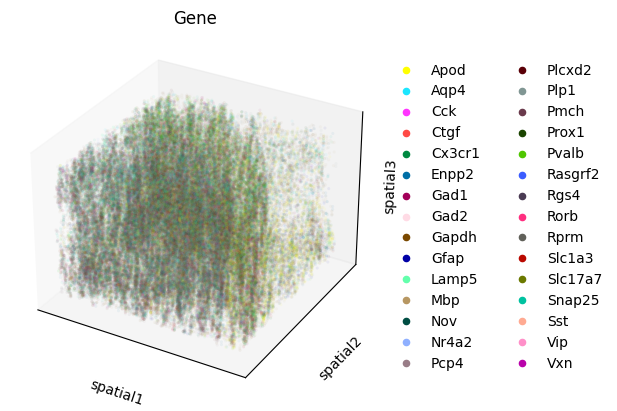

In [75]:
import squidpy as sq
rna_anndata.obsm['spatial'] = rna_df[['x_in_pix', 'y_in_pix', 'z_in_pix', ]].values

plt.figure(figsize=(10,10))
sc.pl.embedding(rna_anndata, basis="spatial", projection="3d", color="Gene", size=0.01, alpha=0.05)  # Set the elevation and azimuth angles
plt.show()

In [17]:
cell_1 = rna_anndata[rna_anndata.obs['Cell Index'] == 0]
sq.gr.spatial_neighbors(cell_1, coord_type="generic", spatial_key="spatial")

In [32]:
sq.gr.spatial_neighbors(rna_anndata, coord_type="generic", spatial_key="spatial",n_neighs=2)

In [33]:
sq.gr.nhood_enrichment(rna_anndata, cluster_key="Gene")

  0%|          | 0/1000 [00:00<?, ?/s]

100%|██████████| 1000/1000 [00:15<00:00, 64.14/s]


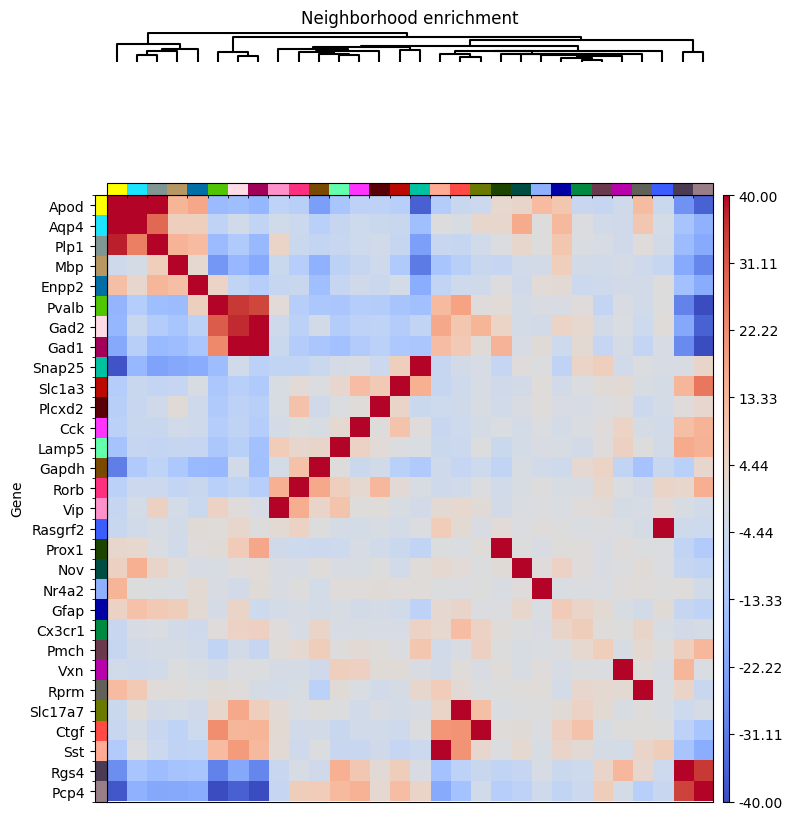

In [35]:
fig,ax = plt.subplots(figsize=(10,10))
sq.pl.nhood_enrichment(
    rna_anndata, 
    cluster_key="Gene", 
    cmap="coolwarm", 
    method="ward",
    vmax=40, vmin=-40,
    ax=ax,
)
plt.show()

# combined analysis of multiple tissues

In [271]:
workdir = r'./processed'
cell_info = pd.DataFrame()
rna_info = pd.DataFrame()

for path in os.listdir(workdir):
    if 'output_for_PRISM3D_mousebrain' in path: continue
    cell_info_tmp = pd.read_csv(os.path.join(workdir, path, 'cell_Info.csv'), index_col=0)
    tissue_type = path.split('_')[-3]
    # if tissue_type == 'HT':
    #     cell_info_tmp['type'] = cell_info_tmp['type'].replace({'Ex-1':'Ex-1_HT'})
    # if tissue_type == 'HP':
    #     cell_info_tmp['type'] = cell_info_tmp['type'].replace({'Ex-5-thalamus':'Ex'})
    cell_info_tmp['tissue'] = [tissue_type] * len(cell_info_tmp)    
    rna_info_tmp = pd.read_csv(os.path.join(workdir, path, 'mapped_genes_processed.csv'), index_col=0)
    rna_info_tmp['tissue'] = [tissue_type] * len(rna_info_tmp)

    dou_index = cell_info_tmp[cell_info_tmp['nu_volume'].isna()].index
    cell_info_tmp = cell_info_tmp[~cell_info_tmp['nu_volume'].isna()]
    rna_info_tmp = rna_info_tmp[~rna_info_tmp.index.isin(dou_index)]

    cell_info = pd.concat([cell_info, cell_info_tmp])
    rna_info = pd.concat([rna_info, rna_info_tmp])

In [272]:
tissue_type_list = ['CTX', 'TH', 'HT', 'HP', ]
cell_type_list =  [
    'Glial-Astrocyte', 'Glial-Oligodendrocyte', 'Glial-Microglia', 
    'In-Sst', 'In-Pvalb', 'In-Vip', 'In-Lamp5',
    
    'Ex-2or3', 'Ex-4', 'Ex-5', 'Ex-6a', 'Ex-6b', 

    'Ex-thalamus', 
    
    'Ex-1', 'Ex-2-Nr4a2+', 'Ex-3-Rorb+', 'Ex-4-Rprm+', 'Ex-4-Pmch+', 'Ex-5-Prox1+', 'Ex-6-Rasgrf2+', 
    'Ex-MH', 'Ex-CA1', 'Ex-CA3', 'Ex-DG', ]

## direct calculation

In [273]:
sorted(list(cell_info.subtype.unique()))

['Ex-1',
 'Ex-2-Nr4a2+',
 'Ex-2or3',
 'Ex-3-Rorb+',
 'Ex-4',
 'Ex-4-Pmch+',
 'Ex-4-Rprm+',
 'Ex-5',
 'Ex-5-Prox1+',
 'Ex-5-other',
 'Ex-6-Rasgrf2+',
 'Ex-6a',
 'Ex-6b',
 'Ex-CA1',
 'Ex-CA3',
 'Ex-DG',
 'Ex-MH',
 'Ex-other',
 'Ex-thalamus',
 'Glial-Astrocyte',
 'Glial-Microglia',
 'Glial-Oligodendrocyte',
 'In-Lamp5',
 'In-Pvalb',
 'In-Sst',
 'In-Vip',
 'In-other',
 'other']

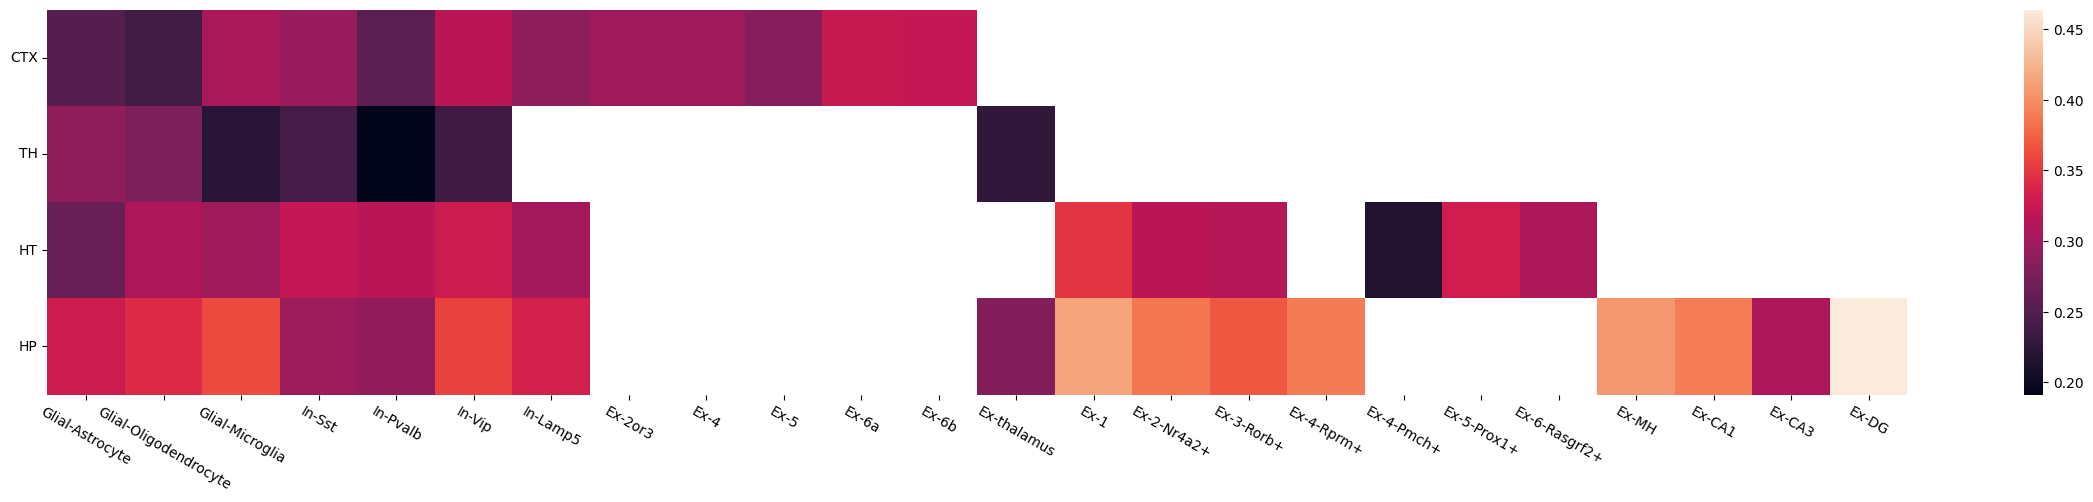

In [274]:
heat_dict = dict()
for tissue in tissue_type_list:
    heat_dict[tissue] = []
    tissue_cell_info = cell_info[cell_info['tissue']==tissue]
    for cell_type in cell_type_list:
        heat_dict[tissue].append(tissue_cell_info[tissue_cell_info['subtype']==cell_type]['in_nu'].mean())

heat_df = pd.DataFrame(heat_dict)
heat_df.index = cell_type_list

fig, ax = plt.subplots(figsize=(30, 5))
sns.heatmap(heat_df.T, ax=ax)
plt.xticks(rotation=-30)
plt.yticks(rotation=0)
plt.show()

## Roe calculation

### in/out

In [319]:
Roe = pd.DataFrame(columns=['tissue', 'cell_type', 'in_nu', 'gene', 'observed', 'expected' ,'Roe'])
for tissue_type in tissue_type_list:
    rna_by_tissue = rna_info[rna_info['tissue'] == tissue_type]
    tmp_observed1 = rna_by_tissue.copy()
    cell_info_by_tissue = cell_info[cell_info['tissue'] == tissue_type]

    for cell_type in tqdm(cell_type_list, desc=tissue_type):
        index = cell_info[cell_info['subtype']==cell_type].index
        rna_by_celltype = rna_info[rna_info['Cell Index'].isin(index)]
        tmp_observed2 = tmp_observed1[tmp_observed1['Cell Index'].isin(cell_info_by_tissue[cell_info_by_tissue['subtype']==cell_type].index)]
                
        for nu in [True, False]:
            rna_by_nu = rna_info[rna_info['in_nu'] == nu]
            tmp_observed3 = tmp_observed2[tmp_observed2['in_nu']==nu]
                
            for gene in gene_order_list:
                rna_by_gene = rna_info[rna_info['Gene'] == gene]
                tmp_observed = tmp_observed3[tmp_observed3['Gene'] == gene]
                tmp_observed = len(tmp_observed)
                tmp_expected = len(rna_by_gene) * len(rna_by_celltype) * len(rna_by_nu) * len(rna_by_tissue) / len(rna_info)**3

                tmp_df = pd.DataFrame({'tissue': [tissue_type], 
                                       'cell_type': [cell_type], 
                                       'in_nu': [nu], 
                                       'gene': [gene], 
                                       'observed': [tmp_observed], 
                                       'expected': [tmp_expected],
                                       'Roe': [tmp_observed/tmp_expected],
                                       })
                Roe = pd.concat([Roe, tmp_df])

HP: 100%|██████████| 24/24 [01:05<00:00,  2.73s/it]


In [320]:
tmp = Roe.copy()
Roe_reduced_in = dict()
Roe_reduced_out = dict()

for tissue_type in tissue_type_list:
    Roe_reduced_in[tissue_type] = []
    Roe_reduced_out[tissue_type] = []
    for cell_type in cell_type_list:
        interest = tmp[tmp['cell_type']==cell_type]
        interest = interest[interest['tissue']==tissue_type]
        interest = interest[interest['Roe']>0]
        Roe_reduced_in[tissue_type].append(interest[interest['in_nu'] == True]['Roe'].mean())
        Roe_reduced_out[tissue_type].append(interest[interest['in_nu'] == False]['Roe'].mean())

Roe_in_df = pd.DataFrame(Roe_reduced_in)
Roe_out_df = pd.DataFrame(Roe_reduced_out)
Roe_in_df.index = cell_type_list
Roe_out_df.index = cell_type_list

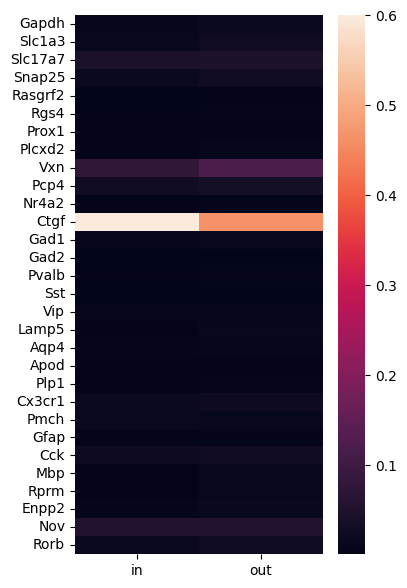

In [324]:
interest = tmp[tmp['cell_type']=='Ex-6b']
interest = interest[interest['tissue']=='CTX']

array = np.array(
   [
        np.array([_ for _ in interest[interest['in_nu'] == True]['Roe']]),
        np.array([_ for _ in interest[interest['in_nu'] == False]['Roe']]),
    ]
    )
fig, ax = plt.subplots(figsize=(4,7))
sns.heatmap(array.T / np.sum(array.T, axis=0), xticklabels=['in', 'out'] ,yticklabels=gene_order_list, ax=ax)
plt.savefig(r'E:\TMC\PRISM_workflow\processed\output_for_PRISM3D_mousebrain\_subcellular\in_out\in_CTX_Ex-6b\Roe.pdf', bbox_inches='tight')
# plt.show()

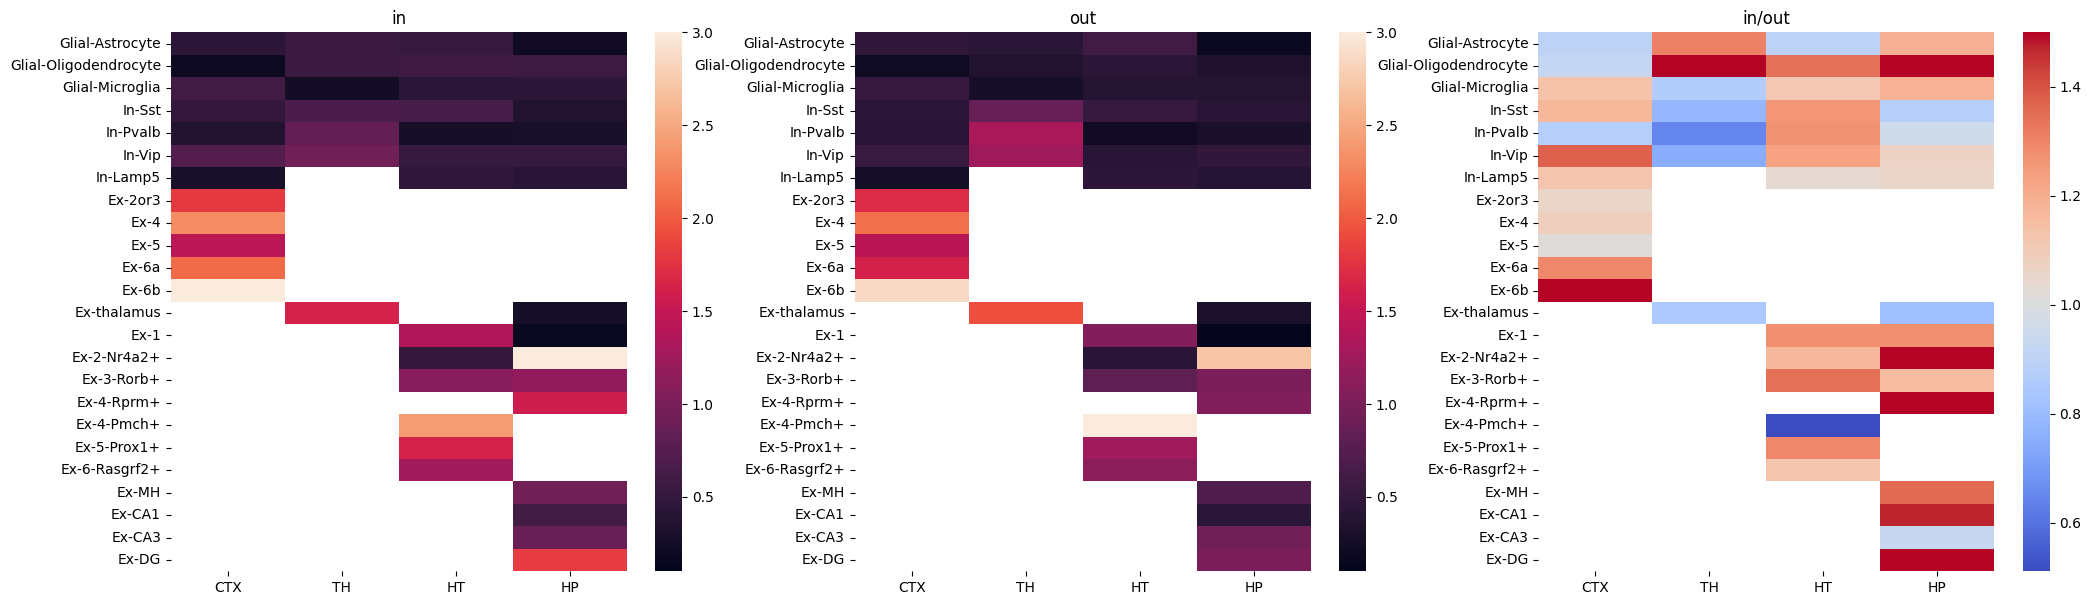

In [278]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(25,7))
sns.heatmap(Roe_in_df, ax=ax[0],
            vmax=3, 
            vmin=0.1,
            )
ax[0].set_title('in')

sns.heatmap(Roe_out_df, ax=ax[1],
            vmax=3,
            vmin=0.1,
            )
ax[1].set_title('out')

sns.heatmap(Roe_in_df / Roe_out_df, 
            cmap='coolwarm', ax=ax[2],
            vmax=1.5, 
            # vmin=0.8,
            )
ax[2].set_title('in/out')
plt.show()
# plt.savefig(os.path.join(workdir, 'output_for_PRISM3D_mousebrain', 'Roe_in_out.pdf'), bbox_inches='tight')

#### Threshold of interested cells

In [ ]:
intere_index = []
interested_cells = cell_info[cell_info['tissue'] == 'HT']
interested_cells = interested_cells[interested_cells['subtype'] == 'Ex-4-Pmch+']
tissue_rna = rna_info[rna_info['tissue'] == 'HT']
split = '='*30
for index in interested_cells.index:    
    tmp = tissue_rna[tissue_rna['Cell Index'] == index]
    # print(tmp)
    if len(tmp) >= 30:
        intere_index.append(index)
        print(f'{split}\n{index}', '\n',tmp[['Gene', 'in_nu']])
print(len(intere_index))
intere_index

#### influence of cell and nucleus size

In [219]:
cell_info

,ce_z_in_pix,ce_x_in_pix,ce_y_in_pix,type,subtype,in_nu,polar,rna_ave_dis,cell_radius,cell_volume,nu_volume,tissue,polar_adjusted
Cell Index,,,,,,,,,,,,,
0,147.84,514.0,462.0,other,other,0.314286,9.427229,30.623014,45.365300,0.00,67173.12,CTX,0.307848
1,90.72,436.0,434.0,Glial,Glial-Microglia,0.448276,14.318238,32.328416,51.630208,126816.48,95266.08,CTX,0.442899
2,161.28,226.0,56.0,Ex,Ex-6b,0.531250,8.326333,28.521276,48.748419,82246.08,91318.08,CTX,0.291934
3,120.96,572.0,538.0,other,other,0.404255,2.303103,31.577172,46.711065,0.00,84631.68,CTX,0.072936
4,215.04,92.0,584.0,other,other,0.535714,7.096833,27.134341,44.370986,0.00,68812.80,CTX,0.261544
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37842,295.68,5374.0,7110.0,Ex,Ex-3-Rorb+,0.046512,22.655538,32.402621,52.672589,101969.28,13033.44,HP,0.699188
37844,292.32,5064.0,6984.0,Ex,Ex-thalamus,0.500000,15.080671,17.898402,16.901432,1848.00,14101.92,HP,0.842571
37845,285.60,5464.0,7322.0,Ex,Ex-4-Rprm+,0.333333,27.659133,34.444607,28.965248,11854.08,7113.12,HP,0.803003


In [220]:
nucleus_dict = dict()
convex_dict = dict()

for tissue_type in tissue_type_list:
    nucleus_dict[tissue_type] = []
    convex_dict[tissue_type] = []
    for cell_type in tqdm(cell_type_list, desc=tissue_type):
        tmp = cell_info[~cell_info['nu_volume'].isna()]
        tmp = tmp[tmp['tissue'] == tissue_type]
        tmp = tmp[tmp['subtype'] == cell_type]
        nucleus_dict[tissue_type].append(tmp['nu_volume'].mean())
        convex_dict[tissue_type].append(tmp['cell_volume'].mean())

nucleus_df = pd.DataFrame(nucleus_dict)
convex_df = pd.DataFrame(convex_dict)
nucleus_df.index = cell_type_list
convex_df.index = cell_type_list

HP: 100%|██████████| 24/24 [00:00<00:00, 115.69it/s]


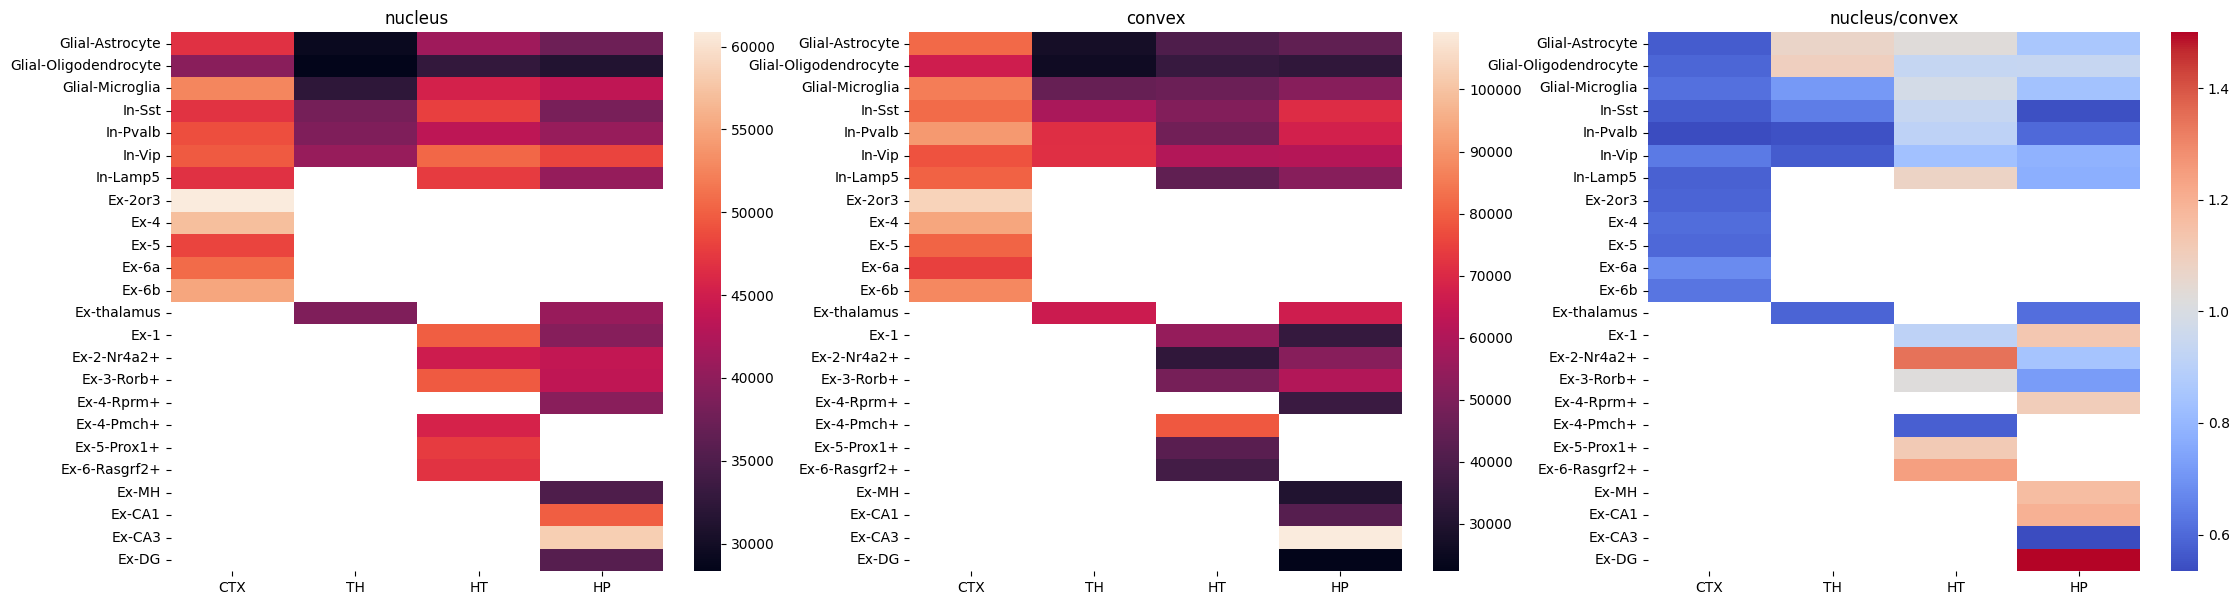

In [237]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(27,7))
sns.heatmap(nucleus_df, 
            ax=ax[0]
            # vmax=3, 
            # vmin=0.75,
            )
ax[0].set_title('nucleus')

sns.heatmap(convex_df, 
            ax=ax[1],
            # vmax=3, 
            # vmin=0.75,
            )
ax[1].set_title('convex')

sns.heatmap(nucleus_df / convex_df, 
            cmap='coolwarm', ax=ax[2],
            vmax=1.5, 
            # vmin=0.8,
            )
ax[2].set_title('nucleus/convex')
# plt.savefig(os.path.join(workdir, 'output_for_PRISM3D_mousebrain', 'nucleus_convex.pdf'), bbox_inches='tight')
plt.show()

### polarity

In [296]:
cell_info

,ce_z_in_pix,ce_x_in_pix,ce_y_in_pix,type,subtype,in_nu,polar,rna_ave_dis,cell_radius,cell_volume,nu_volume,tissue
Cell Index,,,,,,,,,,,,
0,147.84,514.0,462.0,other,other,0.314286,9.427229,30.623014,45.365300,0.00,67173.12,CTX
1,90.72,436.0,434.0,Glial,Glial-Microglia,0.448276,14.318238,32.328416,51.630208,126816.48,95266.08,CTX
2,161.28,226.0,56.0,Ex,Ex-6b,0.531250,8.326333,28.521276,48.748419,82246.08,91318.08,CTX
3,120.96,572.0,538.0,other,other,0.404255,2.303103,31.577172,46.711065,0.00,84631.68,CTX
4,215.04,92.0,584.0,other,other,0.535714,7.096833,27.134341,44.370986,0.00,68812.80,CTX
...,...,...,...,...,...,...,...,...,...,...,...,...
37842,295.68,5374.0,7110.0,Ex,Ex-3-Rorb+,0.046512,22.655538,32.402621,52.672589,101969.28,13033.44,HP
37844,292.32,5064.0,6984.0,Ex,Ex-thalamus,0.500000,15.080671,17.898402,16.901432,1848.00,14101.92,HP
37845,285.60,5464.0,7322.0,Ex,Ex-4-Rprm+,0.333333,27.659133,34.444607,28.965248,11854.08,7113.12,HP


In [297]:
cell_info['polar_adjusted'] = cell_info['polar'] / cell_info['rna_ave_dis']

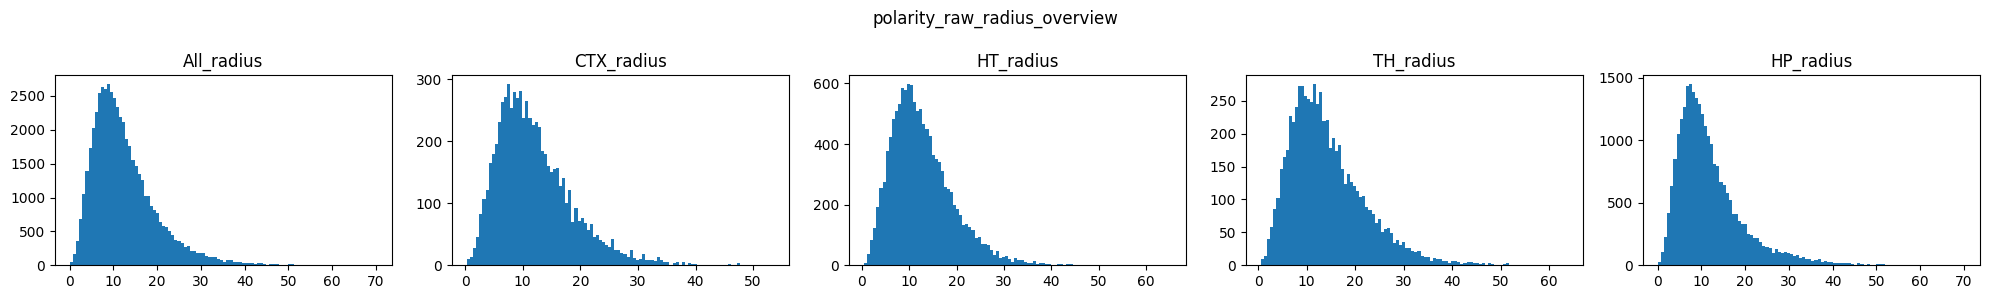

In [298]:
fig, ax=plt.subplots(ncols=5, nrows=1, figsize=(20,3))
ax[0].hist(cell_info['polar'], bins=100)
ax[0].set_title('All_radius')
ax[1].hist(cell_info[cell_info['tissue']=='CTX']['polar'], bins=100)
ax[1].set_title('CTX_radius')
ax[2].hist(cell_info[cell_info['tissue']=='HT']['polar'], bins=100)
ax[2].set_title('HT_radius')
ax[3].hist(cell_info[cell_info['tissue']=='TH']['polar'], bins=100)
ax[3].set_title('TH_radius')
ax[4].hist(cell_info[cell_info['tissue']=='HP']['polar'], bins=100)
ax[4].set_title('HP_radius')
plt.suptitle('polarity_raw_radius_overview')
plt.tight_layout()
plt.show()

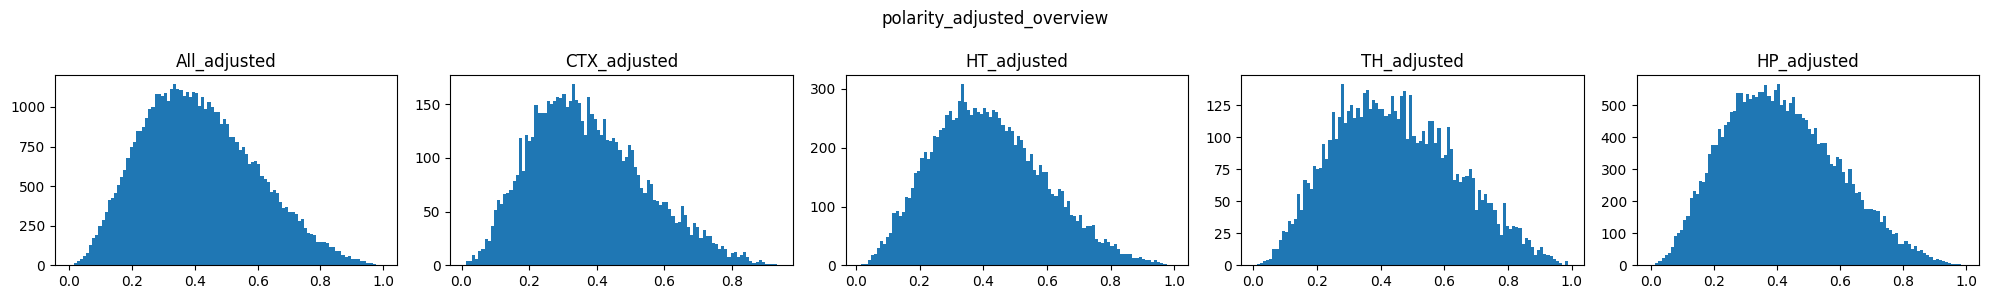

In [299]:
fig, ax=plt.subplots(ncols=5, nrows=1, figsize=(20,3))
ax[0].hist(cell_info['polar_adjusted'], bins=100)
ax[0].set_title('All_adjusted')
ax[1].hist(cell_info[cell_info['tissue']=='CTX']['polar_adjusted'], bins=100)
ax[1].set_title('CTX_adjusted')
ax[2].hist(cell_info[cell_info['tissue']=='HT']['polar_adjusted'], bins=100)
ax[2].set_title('HT_adjusted')
ax[3].hist(cell_info[cell_info['tissue']=='TH']['polar_adjusted'], bins=100)
ax[3].set_title('TH_adjusted')
ax[4].hist(cell_info[cell_info['tissue']=='HP']['polar_adjusted'], bins=100)
ax[4].set_title('HP_adjusted')
plt.suptitle('polarity_adjusted_overview')
plt.tight_layout()
plt.show()

In [300]:
rna_info.index = [_ for _ in range(len(rna_info))]

In [301]:
cell_info

,ce_z_in_pix,ce_x_in_pix,ce_y_in_pix,type,subtype,in_nu,polar,rna_ave_dis,cell_radius,cell_volume,nu_volume,tissue,polar_adjusted
Cell Index,,,,,,,,,,,,,
0,147.84,514.0,462.0,other,other,0.314286,9.427229,30.623014,45.365300,0.00,67173.12,CTX,0.307848
1,90.72,436.0,434.0,Glial,Glial-Microglia,0.448276,14.318238,32.328416,51.630208,126816.48,95266.08,CTX,0.442899
2,161.28,226.0,56.0,Ex,Ex-6b,0.531250,8.326333,28.521276,48.748419,82246.08,91318.08,CTX,0.291934
3,120.96,572.0,538.0,other,other,0.404255,2.303103,31.577172,46.711065,0.00,84631.68,CTX,0.072936
4,215.04,92.0,584.0,other,other,0.535714,7.096833,27.134341,44.370986,0.00,68812.80,CTX,0.261544
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37842,295.68,5374.0,7110.0,Ex,Ex-3-Rorb+,0.046512,22.655538,32.402621,52.672589,101969.28,13033.44,HP,0.699188
37844,292.32,5064.0,6984.0,Ex,Ex-thalamus,0.500000,15.080671,17.898402,16.901432,1848.00,14101.92,HP,0.842571
37845,285.60,5464.0,7322.0,Ex,Ex-4-Rprm+,0.333333,27.659133,34.444607,28.965248,11854.08,7113.12,HP,0.803003


In [302]:
low_medium_thre = np.nanpercentile(cell_info['polar_adjusted'], 20)
medium_high_thre = np.nanpercentile(cell_info['polar_adjusted'], 80)

rna_info['polar_type'] = [np.nan] * len(rna_info)
for tissue_type in tissue_type_list:
    tmp_observed1 = rna_info[rna_info['tissue'] == tissue_type]
    for cell_type in tqdm(cell_type_list, desc=tissue_type):
        index = cell_info[cell_info['subtype']==cell_type].index
        tmp_observed2 = tmp_observed1[tmp_observed1['Cell Index'].isin(index)]
        for gene in gene_order_list:
            tmp_observed3 = tmp_observed2[tmp_observed2['Gene']==gene]
            for cell_index in tmp_observed3['Cell Index'].unique():
                gene_in_cell_rna = tmp_observed3[tmp_observed3['Cell Index']==cell_index]
                if len(gene_in_cell_rna) < 5:
                    continue
                else:
                    try: cell_tmp = cell_info[cell_info['tissue']==tissue_type].loc[cell_index]
                    except: continue
                    polarity_tmp = euclidean(np.mean(gene_in_cell_rna[['z_in_pix', 'x_in_pix', 'y_in_pix', ]].values, axis=0), cell_tmp[['ce_z_in_pix', 'ce_x_in_pix', 'ce_y_in_pix']].values) / cell_tmp['rna_ave_dis']
                    if polarity_tmp < low_medium_thre:
                        rna_info['polar_type'].loc[gene_in_cell_rna.index] = ['low'] * len(gene_in_cell_rna)
                    elif low_medium_thre <= polarity_tmp < medium_high_thre:
                        rna_info['polar_type'].loc[gene_in_cell_rna.index] = ['medium'] * len(gene_in_cell_rna)
                    else:
                        rna_info['polar_type'].loc[gene_in_cell_rna.index] = ['high'] * len(gene_in_cell_rna)

HP: 100%|██████████| 24/24 [03:01<00:00,  7.57s/it]


In [303]:
Roe = pd.DataFrame(columns=['tissue', 'cell_type', 'polarity', 'gene', 'observed', 'expected' ,'Roe'])
for tissue_type in tissue_type_list:
    rna_by_tissue = rna_info[rna_info['tissue'] == tissue_type]
    tmp_observed1 = rna_by_tissue.copy()
    cell_info_by_tissue = cell_info[cell_info['tissue'] == tissue_type]
                
    for cell_type in tqdm(cell_type_list, desc=tissue_type):
        index = cell_info[cell_info['subtype']==cell_type].index
        rna_by_celltype = rna_info[rna_info['Cell Index'].isin(index)]
        tmp_observed2 = tmp_observed1[tmp_observed1['Cell Index'].isin(cell_info_by_tissue[cell_info_by_tissue['subtype']==cell_type].index)]
                
        for polarity in ['high', 'medium', 'low']:
            rna_by_po = rna_info[rna_info['polar_type'] == polarity]
            tmp_observed3 = tmp_observed2[tmp_observed2['polar_type']==polarity]
                
            for gene in gene_order_list:
                rna_by_gene = rna_info[rna_info['Gene'] == gene]
                tmp_observed = tmp_observed3[tmp_observed3['Gene'] == gene]
                tmp_observed = len(tmp_observed)
                tmp_expected = len(rna_by_gene) * len(rna_by_celltype) * len(rna_by_po) * len(rna_by_tissue) / len(rna_info)**3

                tmp_df = pd.DataFrame({'tissue': [tissue_type], 
                                       'cell_type': [cell_type], 
                                       'polarity': [polarity], 
                                       'gene': [gene], 
                                       'observed': [tmp_observed], 
                                       'expected': [tmp_expected],
                                       'Roe': [tmp_observed/tmp_expected],
                                       })
                Roe = pd.concat([Roe, tmp_df])

HP: 100%|██████████| 24/24 [01:35<00:00,  3.96s/it]


In [230]:
cell_info.subtype.unique()

array(['other', 'Glial-Microglia', 'Ex-6b', 'Glial-Astrocyte', 'Ex-6a',
       'Ex-5', 'Ex-2or3', 'Glial-Oligodendrocyte', 'In-Sst', 'In-Lamp5',
       'In-Pvalb', 'In-Vip', 'Ex-4', 'Ex-5-Prox1+', 'Ex-other',
       'In-other', 'Ex-1', 'Ex-3-Rorb+', 'Ex-6-Rasgrf2+', 'Ex-4-Pmch+',
       'Ex-2-Nr4a2+', 'Ex-thalamus', 'Ex-DG', 'Ex-CA1', 'Ex-5-other',
       'Ex-4-Rprm+', 'Ex-CA3', 'Ex-MH'], dtype=object)

In [304]:
tmp = Roe.copy()
Roe_reduced_po_high = dict()
Roe_reduced_po_medium = dict()
Roe_reduced_po_low = dict()

for tissue_type in tissue_type_list:
    Roe_reduced_po_high[tissue_type] = []
    Roe_reduced_po_medium[tissue_type] = []
    Roe_reduced_po_low[tissue_type] = []
    for cell_type in cell_type_list:
        interest = tmp[tmp['cell_type']==cell_type]
        interest = interest[interest['tissue']==tissue_type]
        interest = interest[interest['Roe']>0]
        Roe_reduced_po_high[tissue_type].append(interest[interest['polarity'] == 'high']['Roe'].mean())
        Roe_reduced_po_medium[tissue_type].append(interest[interest['polarity'] == 'medium']['Roe'].mean())
        Roe_reduced_po_low[tissue_type].append(interest[interest['polarity'] == 'medium']['Roe'].mean())

Roe_po_high_df = pd.DataFrame(Roe_reduced_po_high)
Roe_po_medium_df = pd.DataFrame(Roe_reduced_po_medium)
Roe_po_low_df = pd.DataFrame(Roe_reduced_po_low)
Roe_po_high_df.index = cell_type_list
Roe_po_medium_df.index = cell_type_list
Roe_po_low_df.index = cell_type_list

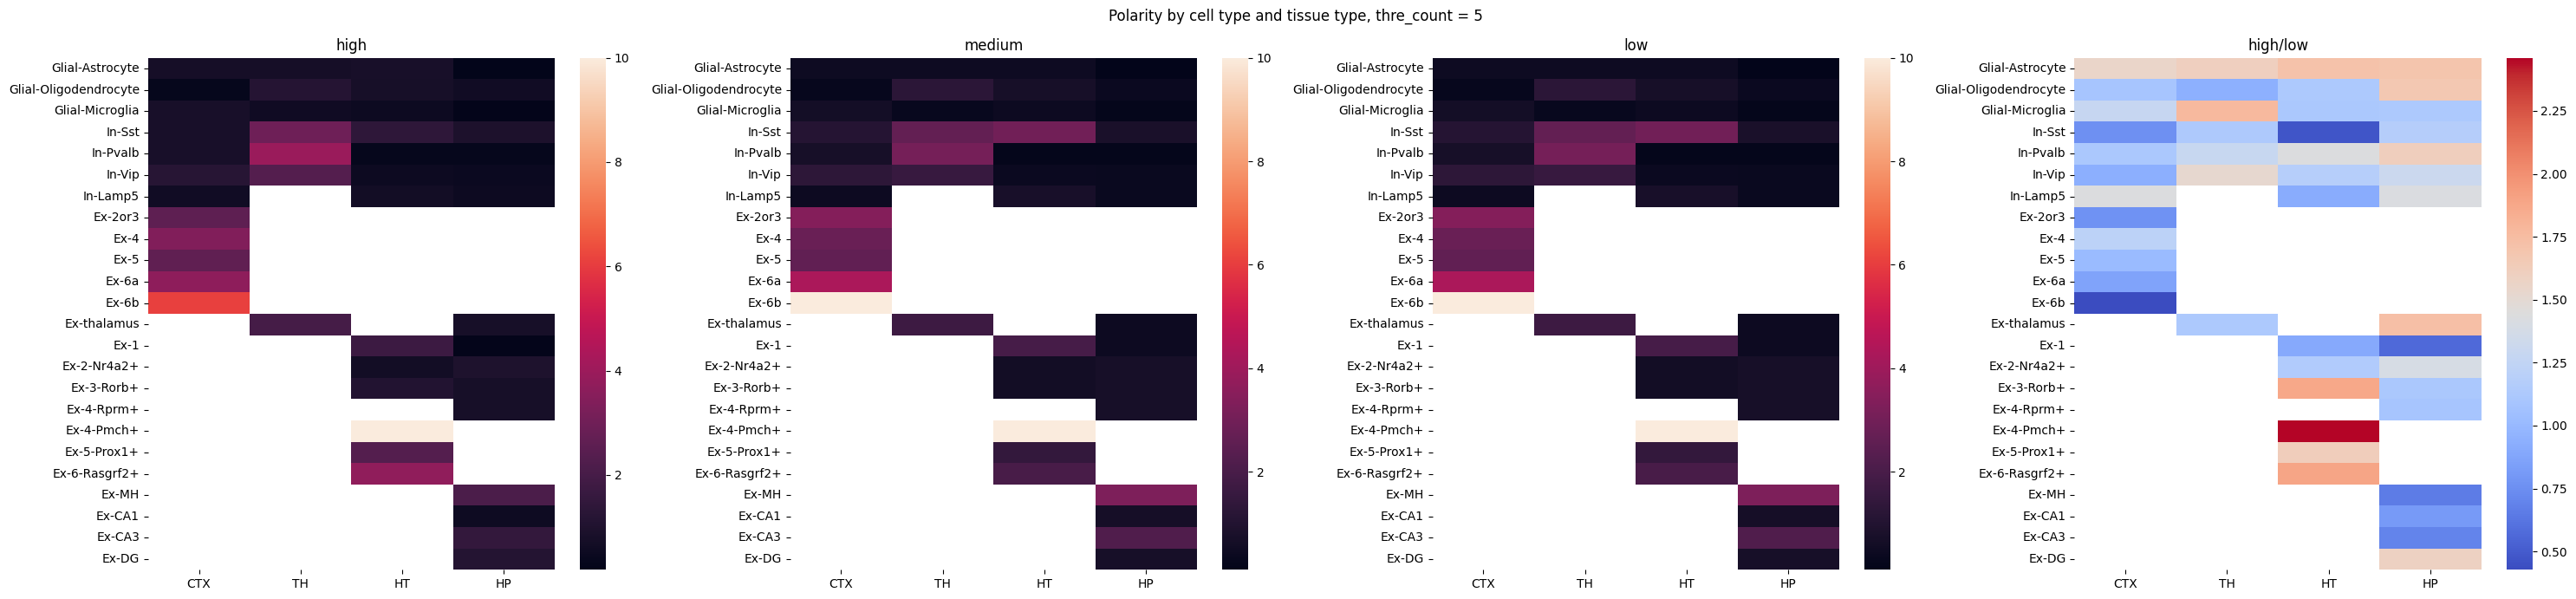

In [305]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(30, 7))
sns.heatmap(Roe_po_high_df, ax=ax[0],
            vmax=10, 
            # vmin=0.1,
            )
ax[0].set_title('high')

sns.heatmap(Roe_po_medium_df, ax=ax[1],
            vmax=10,
            # vmin=0.1,
            )
ax[1].set_title('medium')

sns.heatmap(Roe_po_low_df, ax=ax[2],
            vmax=10,
            # vmin=0.1,
            )
ax[2].set_title('low')

sns.heatmap(Roe_po_high_df / Roe_po_low_df, 
            cmap='coolwarm', ax=ax[3], 
            # vmax=1.5, 
            # vmin=0.8, 
            )
ax[3].set_title('high/low')

plt.suptitle('Polarity by cell type and tissue type, thre_count = 5')
plt.tight_layout()
# plt.savefig(os.path.join(workdir, 'output_for_PRISM3D_mousebrain', 'Roe_polarity.pdf'), bbox_inches='tight')
plt.show()

#### Threshold of interested cells

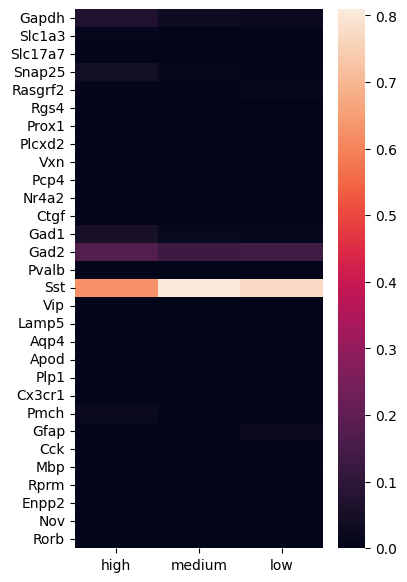

In [317]:
tmp = Roe.copy()
interest = tmp[tmp['cell_type']=='In-Sst']
interest = interest[interest['tissue']=='HT']

array = np.array(
   [
        np.array([_ for _ in interest[interest['polarity'] == 'high']['Roe']]),
        np.array([_ for _ in interest[interest['polarity'] == 'medium']['Roe']]),
        np.array([_ for _ in interest[interest['polarity'] == 'low']['Roe']]),
    ]
    )
fig, ax = plt.subplots(figsize=(4,7))
sns.heatmap(array.T / np.sum(array.T, axis=0), xticklabels=['high', 'medium', 'low'] ,yticklabels=gene_order_list, ax=ax)
plt.show()
# plt.savefig(r'E:\TMC\PRISM_workflow\processed\output_for_PRISM3D_mousebrain\_subcellular\polarity\low_HT_In-Sst\Roe.pdf', bbox_inches='tight')

In [328]:
intere_index = []
interested_cells = cell_info[cell_info['tissue'] == 'HT']
interested_cells = interested_cells[interested_cells['subtype'] == 'Ex-4-Pmch+']
tissue_rna = rna_info[rna_info['tissue'] == 'HT']
split = '='*30
for index in interested_cells.index:    
    tmp = tissue_rna[tissue_rna['Cell Index'] == index]
    # print(tmp)
    if len(tmp[tmp['Gene']=='Pmch']) >= 25:
        intere_index.append(index)
        print(f'{split}\n{index}', '\n',tmp[['Gene', 'polar_type']])
print(len(intere_index))
intere_index

1504 
           Gene polar_type
207285  Plcxd2        NaN
209004  Plcxd2        NaN
250163    Gad2        NaN
265961  Slc1a3        NaN
269774  Slc1a3        NaN
...        ...        ...
410377    Gad1        NaN
412558     Cck        NaN
416915    Rgs4        NaN
419542   Lamp5        NaN
421364   Lamp5        NaN

[69 rows x 2 columns]
2005 
           Gene polar_type
207183  Plcxd2        NaN
230488    Gad2        NaN
234753    Gad2        NaN
252291     Vxn        NaN
257936     Mbp        NaN
...        ...        ...
412360     Cck        NaN
412370     Cck        NaN
413188     Cck        NaN
419930   Lamp5        NaN
420863   Lamp5        NaN

[93 rows x 2 columns]
2115 
           Gene polar_type
207165  Plcxd2        NaN
209874  Plcxd2        NaN
226374    Gad2     medium
227987    Gad2     medium
230439    Gad2     medium
...        ...        ...
404089    Gad1     medium
404150    Gad1     medium
409311    Gad1     medium
418547   Lamp5        NaN
421277   Lamp5        N

[1504,
 2005,
 2115,
 2142,
 2227,
 2397,
 2521,
 2565,
 2618,
 3141,
 3196,
 3243,
 3257,
 3292,
 3383,
 3398,
 3404,
 3434,
 3511,
 3666,
 3713,
 3715,
 3957,
 4287,
 4316,
 4365,
 4446,
 7797,
 7808,
 7944,
 7949,
 8056,
 8149,
 8155,
 8162,
 8343,
 8401,
 8409,
 8421,
 8454,
 8456,
 8486,
 8513,
 8551,
 8633,
 8640,
 8641,
 8761,
 8840,
 8856,
 8858,
 8876,
 10277,
 10737,
 11167,
 13463,
 13511,
 13813,
 13868,
 13957]

In [ ]:
gene_order_list